# **FROM TEST DATASET**

Unzipping test data...
Unzip complete!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model loaded successfully!
Loading and preprocessing test data...
Processing category: disgust (label: 1)
Processed 100 images so far...
Processing category: sad (label: 4)
Processed 200 images so far...
Processed 300 images so far...
Processed 400 images so far...
Processed 500 images so far...
Processed 600 images so far...
Processed 700 images so far...
Processed 800 images so far...
Processed 900 images so far...
Processed 1000 images so far...
Processed 1100 images so far...
Processed 1200 images so far...
Processed 1300 images so far...
Processing category: surprise (label: 5)
Processed 1400 images so far...
Processed 1500 images so far...
Processed 1600 images so far...
Processed 1700 images so far...
Processed 1800 images so far...
Processed 1900 images so far...
Processed 2000 images so far...
Processed 2100 images so far...
Processing category: angry (label: 0)
Processed 2200 images so far...
Processed 2300 images so far...
Processed 2400 images so far...
Processed 2500 image

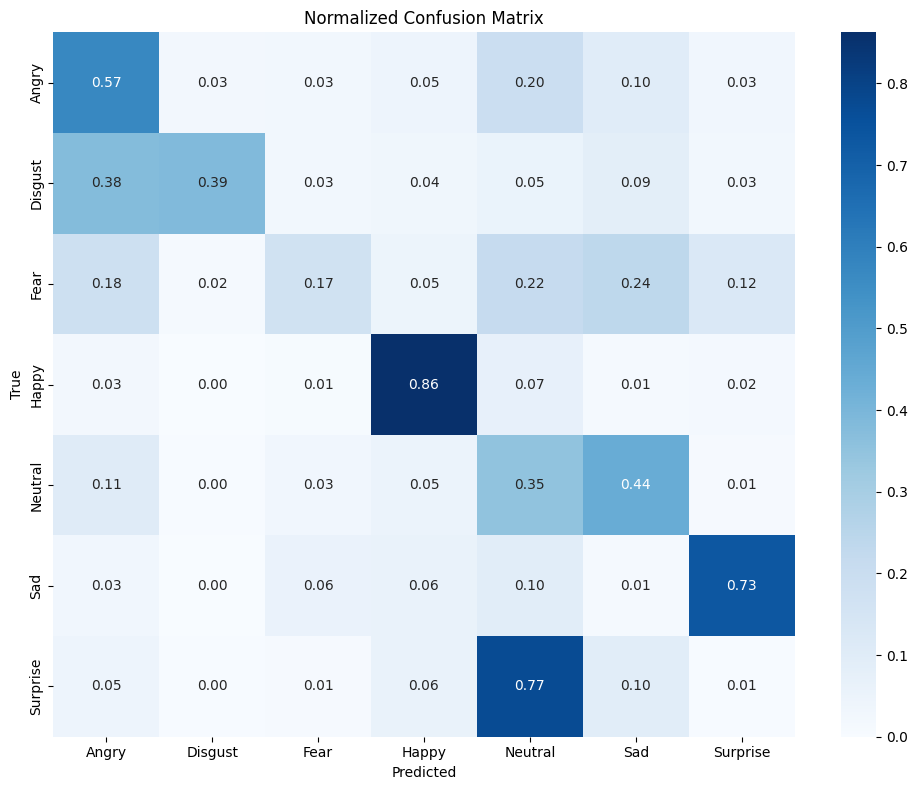

<Figure size 1200x600 with 0 Axes>

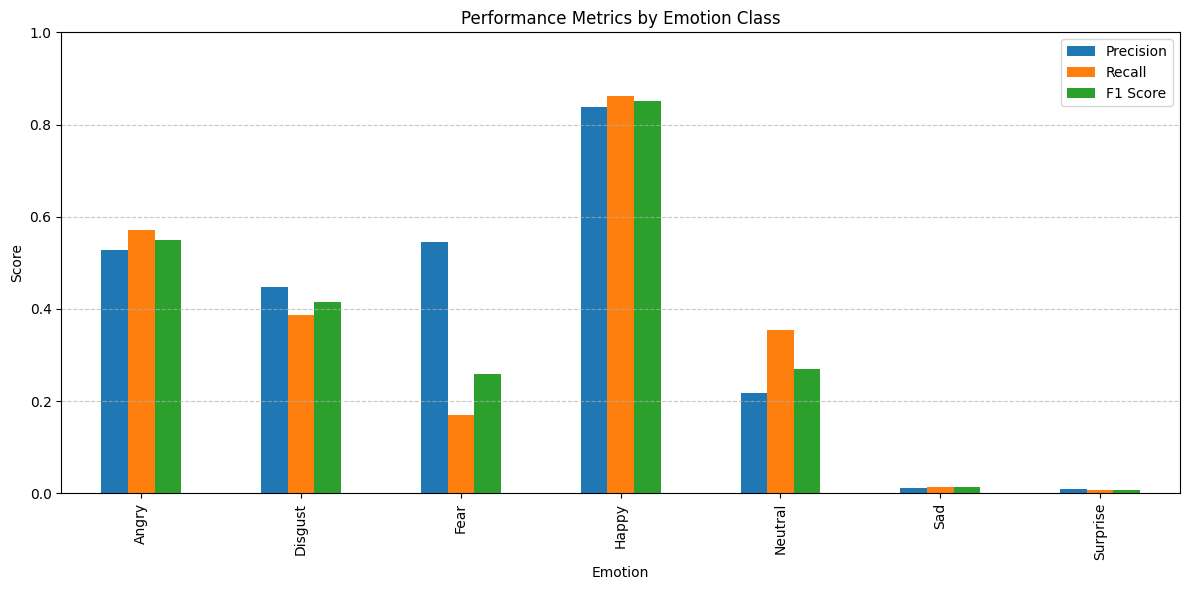

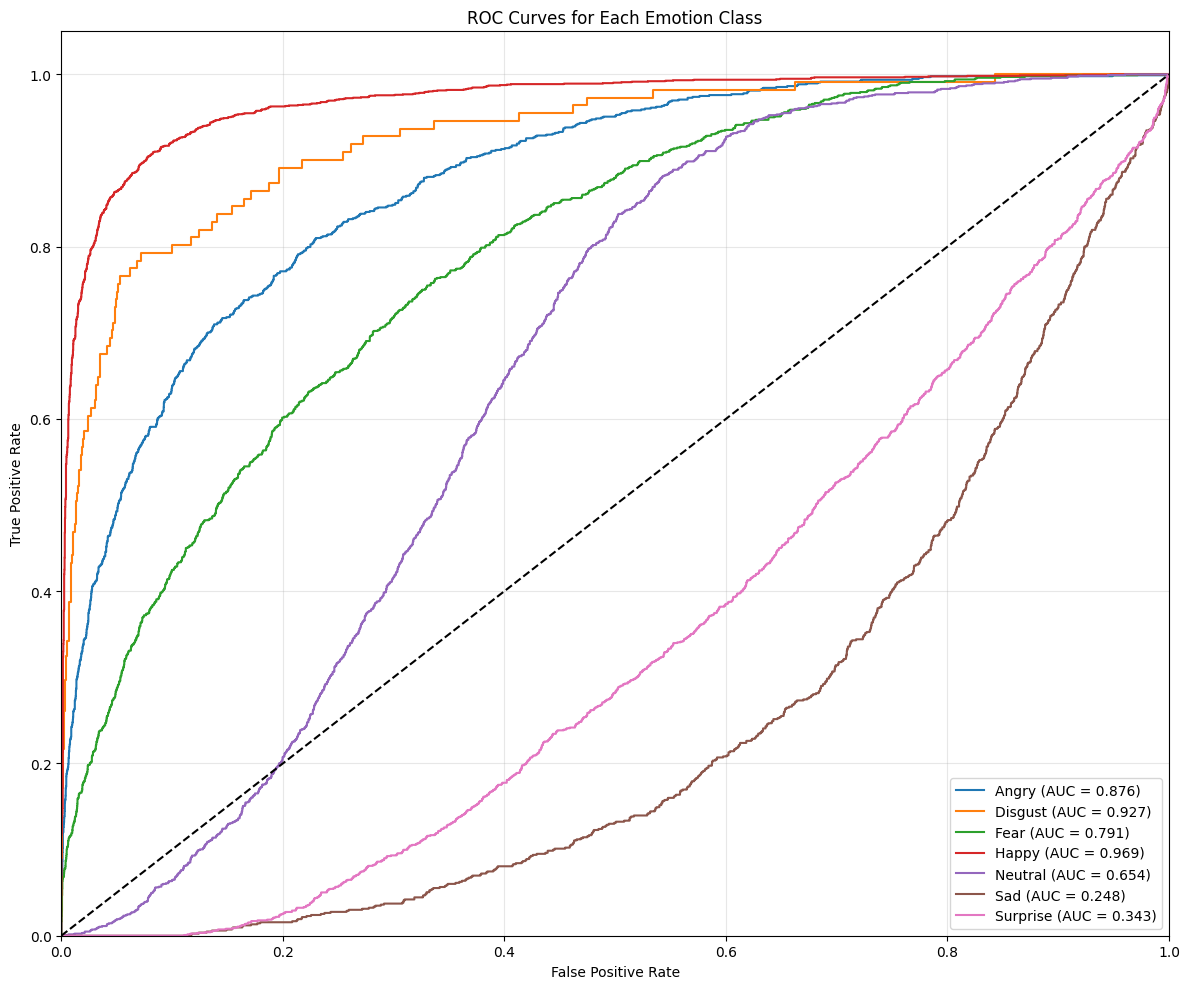

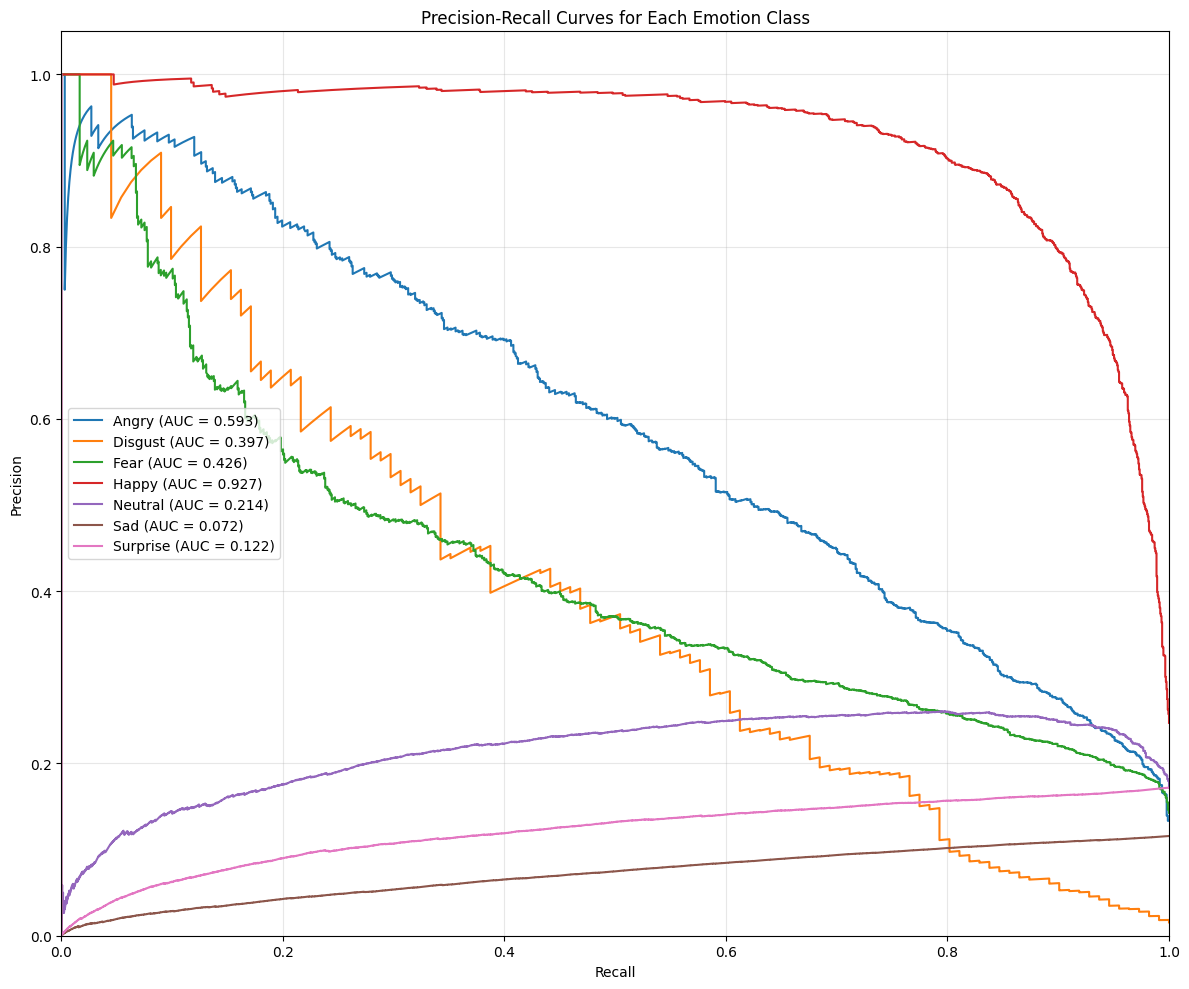

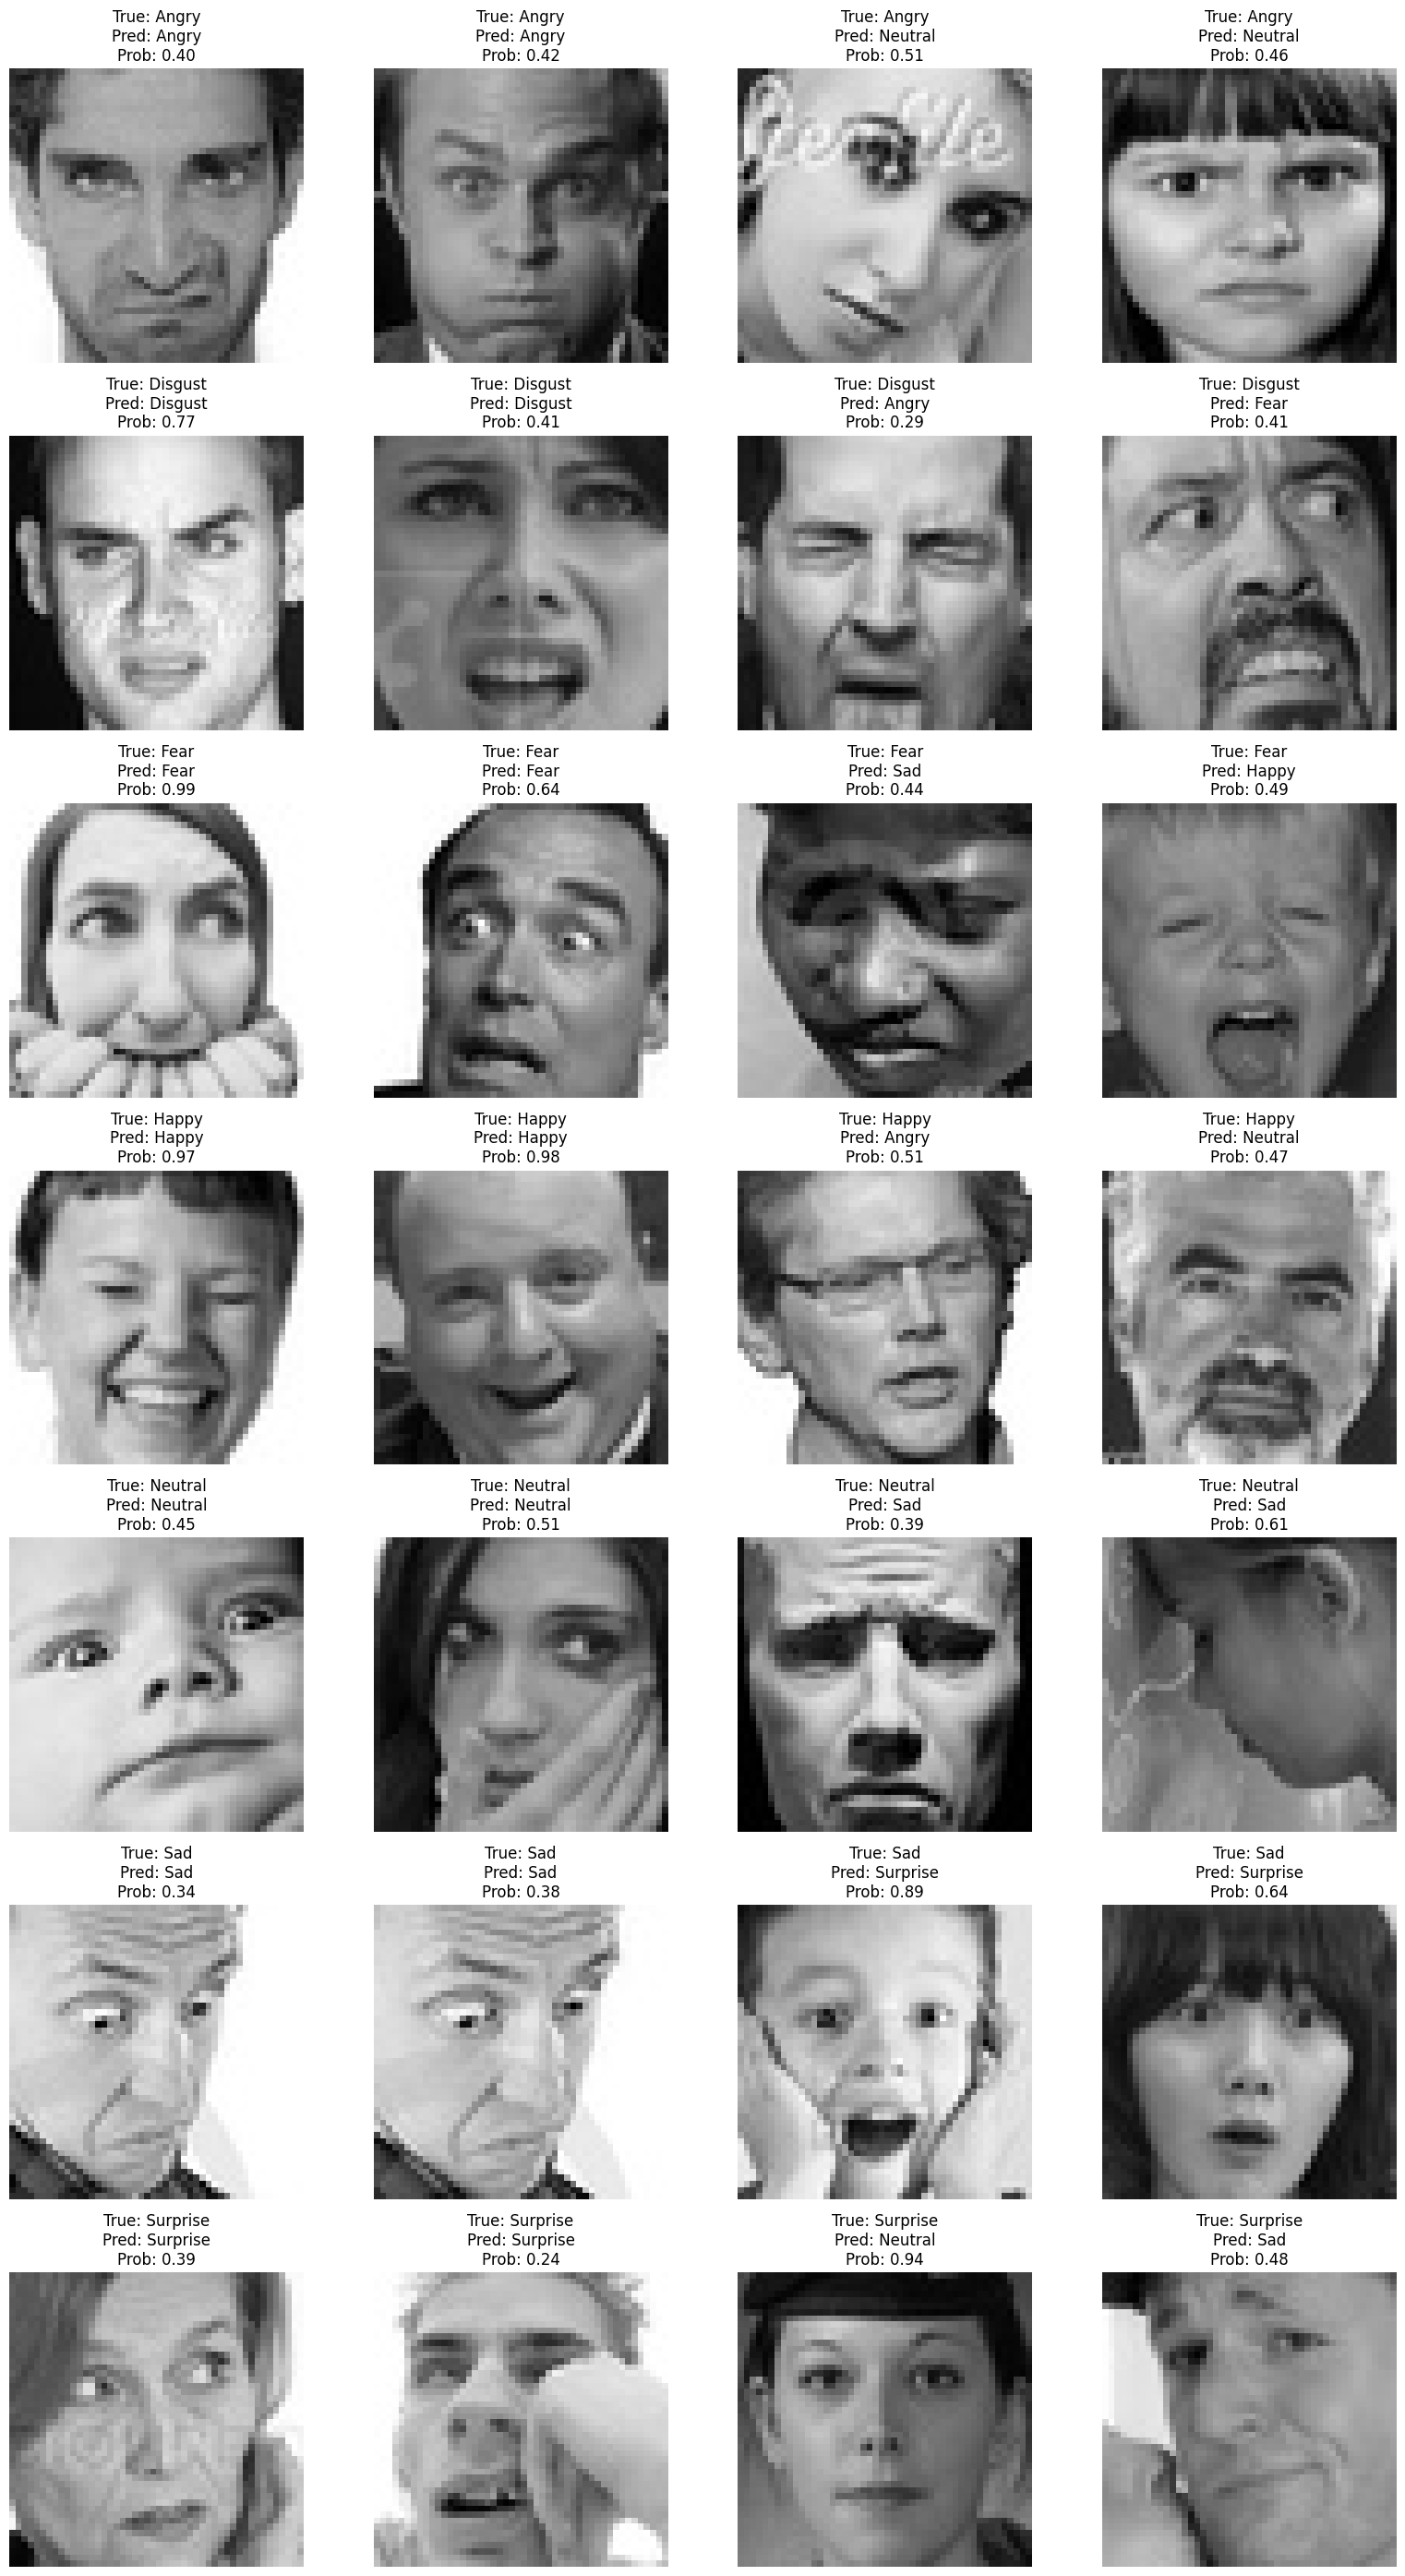

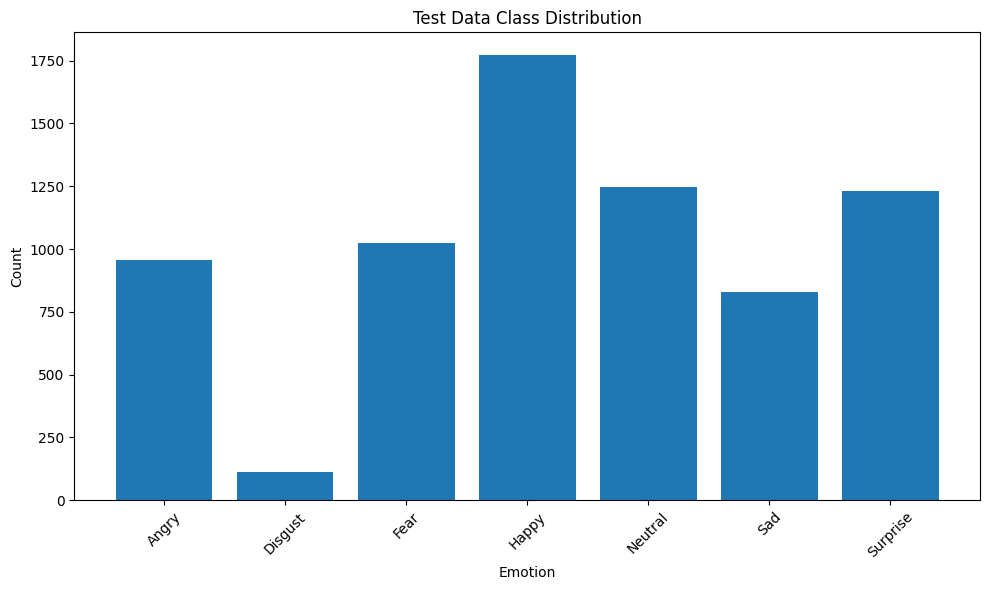


--- Saving Comprehensive Report ---
    Emotion  Count  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0     Angry    958  0.572025   0.527938  0.572025  0.549098  0.875684   
1   Disgust    111  0.387387   0.447917  0.387387  0.415459  0.926972   
2      Fear   1024  0.168945   0.545741  0.168945  0.258016  0.790943   
3     Happy   1774  0.862458   0.838356  0.862458  0.850236  0.968613   
4   Neutral   1247  0.353649   0.218101  0.353649  0.269807  0.653824   
5       Sad    831  0.014440   0.011396  0.014440  0.012739  0.247546   
6  Surprise   1233  0.006488   0.009674  0.006488  0.007767  0.342754   
7   Overall   7178  0.383812   0.403307  0.383812  0.376329       NaN   

     PR AUC  
0  0.593367  
1  0.397326  
2  0.426410  
3  0.927246  
4  0.214100  
5  0.071566  
6  0.121522  
7       NaN  

Evaluation complete! All results have been saved.


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import tensorflow as tf
import cv2
from PIL import Image
import io
import itertools

# Define the emotion labels for FER2013
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

# 1. Unzip the test data
print("Unzipping test data...")
with zipfile.ZipFile('/content/test.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
print("Unzip complete!")

# 2. Load the pre-trained model
model_path = '/content/CNN.h5'  # Update this path to your .h5 file location
model = load_model(model_path)
print("Model loaded successfully!")

# 3. Data preprocessing function
def preprocess_images(img_paths, target_size=(48, 48), channels=3):
    """
    Preprocess images for the FER2013 model

    Parameters:
    - img_paths: Path to image directory
    - target_size: Size to resize images to (default: 48x48)
    - channels: Number of channels expected by the model (default: 3 for RGB)
    """
    images = []
    image_paths = []
    labels = []

    # Define emotion mapping (both ways)
    emotion_labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
    emotion_to_label = {v: k for k, v in emotion_labels.items()}  # Reverse mapping: text to number

    for category in os.listdir(img_paths):
        if os.path.isdir(os.path.join(img_paths, category)):
            category_path = os.path.join(img_paths, category)

            # Handle both numeric and text folder names
            try:
                # Try to convert directly to int (for numeric folder names like "0", "1", etc.)
                label = int(category)
                if label < 0 or label > 6:
                    print(f"Warning: Folder name '{category}' is out of valid range (0-6), skipping")
                    continue
            except ValueError:
                # If conversion fails, it's a text folder name (like "angry", "happy", etc.)
                category_lower = category.lower()
                if category_lower in emotion_to_label:
                    label = emotion_to_label[category_lower]
                else:
                    print(f"Warning: Unknown category '{category}', skipping")
                    continue

            print(f"Processing category: {category} (label: {label})")

            # Process all images in this category folder
            for img_file in os.listdir(category_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(category_path, img_file)
                    try:
                        # Read image - use regular imread to handle both grayscale and color
                        img = cv2.imread(img_path)
                        if img is None:
                            print(f"Warning: Could not read image {img_path}, skipping")
                            continue

                        # Convert BGR to RGB (OpenCV loads as BGR)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                        # Resize to target size
                        img = cv2.resize(img, target_size)

                        # Ensure we have the right number of channels
                        if channels == 1 and img.ndim == 3:
                            # Convert to grayscale if model expects 1 channel
                            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                            img = img[:, :, np.newaxis]  # Add channel dimension back
                        elif channels == 3 and img.ndim == 2:
                            # Convert grayscale to 3-channel if model expects RGB
                            img = np.stack((img,) * 3, axis=-1)
                        elif channels == 3 and img.shape[2] != 3:
                            # Fix if somehow we don't have 3 channels
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                        # Normalize image
                        img = img / 255.0

                        images.append(img)
                        image_paths.append(img_path)
                        labels.append(label)

                        # Add progress indicator for large datasets
                        if len(images) % 100 == 0:
                            print(f"Processed {len(images)} images so far...")

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    if not images:
        raise ValueError(f"No valid images found in {img_paths}. Check your directory structure.")

    # Convert to arrays
    X = np.array(images)
    y = np.array(labels)

    # Print the shape to verify
    print(f"Preprocessed data shape: {X.shape}, Labels shape: {y.shape}")
    print(f"Processed {len(images)} images across {len(set(labels))} emotion categories")

    return X, y, image_paths
# 4. Load and preprocess test data
print("Loading and preprocessing test data...")
test_data_path = 'test'  # Update if your test data is in a different directory after unzipping
X_test, y_test, test_image_paths = preprocess_images(test_data_path)
print(f"Test data loaded: {X_test.shape[0]} images")

# 5. Make predictions
print("Making predictions...")
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# 6. Calculate performance metrics
print("\n--- Model Performance Metrics ---")

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# Classification report
class_report = classification_report(y_test, y_pred, target_names=[emotion_labels[i] for i in range(7)], output_dict=True)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[emotion_labels[i] for i in range(7)]))

# Save report as DataFrame for visualization
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df = class_report_df.drop('accuracy', errors='ignore')

# 7. Calculate classwise metrics
classwise_metrics = {}
for class_idx in range(7):
    class_name = emotion_labels[class_idx]

    # Binary classification metrics for this class (one-vs-all)
    y_true_binary = (y_test == class_idx).astype(int)
    y_pred_binary = (y_pred == class_idx).astype(int)
    y_score = y_pred_prob[:, class_idx]

    # Metrics
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_score)
    pr_auc = auc(recall_curve, precision_curve)

    classwise_metrics[class_name] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve,
        'pr_auc': pr_auc
    }

# 8. Visualizations
print("\n--- Creating Visualizations ---")

# 8.1 Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[emotion_labels[i] for i in range(7)],
            yticklabels=[emotion_labels[i] for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 8.2 Classification metrics by class
plt.figure(figsize=(12, 6))
metrics_df = pd.DataFrame({
    'Precision': [classwise_metrics[emotion_labels[i]]['precision'] for i in range(7)],
    'Recall': [classwise_metrics[emotion_labels[i]]['recall'] for i in range(7)],
    'F1 Score': [classwise_metrics[emotion_labels[i]]['f1_score'] for i in range(7)]
}, index=[emotion_labels[i] for i in range(7)])

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Performance Metrics by Emotion Class')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('classwise_metrics.png')
plt.show()

# 8.3 ROC Curves
plt.figure(figsize=(12, 10))
for i in range(7):
    class_name = emotion_labels[i]
    metrics = classwise_metrics[class_name]
    plt.plot(metrics['fpr'], metrics['tpr'], label=f'{class_name} (AUC = {metrics["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Emotion Class')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()

# 8.4 Precision-Recall Curves
plt.figure(figsize=(12, 10))
for i in range(7):
    class_name = emotion_labels[i]
    metrics = classwise_metrics[class_name]
    plt.plot(metrics['recall_curve'], metrics['precision_curve'],
             label=f'{class_name} (AUC = {metrics["pr_auc"]:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Emotion Class')
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png')
plt.show()

# 8.5 Display examples of correct and incorrect predictions
def plot_examples(X, y_true, y_pred, pred_probs, n_per_class=2):
    """
    Plot examples of correct and incorrect predictions for each class
    Works with both grayscale (1-channel) and RGB (3-channel) images
    """
    fig, axes = plt.subplots(7, 4, figsize=(16, 28))

    # Determine if images are grayscale or RGB
    is_rgb = len(X.shape) == 4 and X.shape[3] == 3

    for class_idx in range(7):
        # Get indices where true label is this class
        class_indices = np.where(y_true == class_idx)[0]

        if len(class_indices) == 0:
            continue

        # Find correct and incorrect predictions
        correct = class_indices[y_pred[class_indices] == class_idx]
        incorrect = class_indices[y_pred[class_indices] != class_idx]

        # Select samples
        correct_samples = correct[:n_per_class] if len(correct) > 0 else []
        incorrect_samples = incorrect[:n_per_class] if len(incorrect) > 0 else []

        # Plot correct predictions
        for i, idx in enumerate(correct_samples):
            if i < n_per_class:
                ax = axes[class_idx, i]

                # Handle both RGB and grayscale images
                img = X[idx]
                if is_rgb:
                    # For RGB images, no need to reshape
                    ax.imshow(img)
                else:
                    # For grayscale images, reshape to 2D
                    img = img.reshape(48, 48)
                    ax.imshow(img, cmap='gray')

                prob = pred_probs[idx, class_idx]
                ax.set_title(f"True: {emotion_labels[class_idx]}\nPred: {emotion_labels[y_pred[idx]]}\nProb: {prob:.2f}")
                ax.axis('off')

        # Plot incorrect predictions
        for i, idx in enumerate(incorrect_samples):
            if i < n_per_class:
                ax = axes[class_idx, i + n_per_class]

                # Handle both RGB and grayscale images
                img = X[idx]
                if is_rgb:
                    # For RGB images, no need to reshape
                    ax.imshow(img)
                else:
                    # For grayscale images, reshape to 2D
                    img = img.reshape(48, 48)
                    ax.imshow(img, cmap='gray')

                prob = pred_probs[idx, y_pred[idx]]
                ax.set_title(f"True: {emotion_labels[class_idx]}\nPred: {emotion_labels[y_pred[idx]]}\nProb: {prob:.2f}")
                ax.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

# Plot examples
plot_examples(X_test, y_test, y_pred, y_pred_prob)

# 8.6 Class distribution
plt.figure(figsize=(10, 6))
class_counts = pd.Series(y_test).value_counts().sort_index()
class_names = [emotion_labels[i] for i in range(7)]
plt.bar(class_names, [class_counts.get(i, 0) for i in range(7)])
plt.title('Test Data Class Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# 9. Save all the metrics in a comprehensive report
print("\n--- Saving Comprehensive Report ---")

# Create a pandas DataFrame with all the metrics
metrics_summary = {
    'Emotion': [emotion_labels[i] for i in range(7)],
    'Count': [np.sum(y_test == i) for i in range(7)],
    'Accuracy': [np.mean(y_pred[y_test == i] == i) for i in range(7)],
    'Precision': [classwise_metrics[emotion_labels[i]]['precision'] for i in range(7)],
    'Recall': [classwise_metrics[emotion_labels[i]]['recall'] for i in range(7)],
    'F1 Score': [classwise_metrics[emotion_labels[i]]['f1_score'] for i in range(7)],
    'ROC AUC': [classwise_metrics[emotion_labels[i]]['roc_auc'] for i in range(7)],
    'PR AUC': [classwise_metrics[emotion_labels[i]]['pr_auc'] for i in range(7)]
}

metrics_df = pd.DataFrame(metrics_summary)

# Calculate overall metrics
overall_metrics = {
    'Emotion': 'Overall',
    'Count': len(y_test),
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'ROC AUC': np.nan,  # Not applicable for multiclass without averaging
    'PR AUC': np.nan    # Not applicable for multiclass without averaging
}

# Append overall metrics to the DataFrame
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_metrics])], ignore_index=True)

# Display and save the metrics
print(metrics_df)
metrics_df.to_csv('fer2013_evaluation_metrics.csv', index=False)

print("\nEvaluation complete! All results have been saved.")

# **REAL TIME IMAGES**

🔍 Found zip file. Extracting dataset...
📦 Extracting /content/train.zip to /content...
✅ Extraction complete!
📂 Creating plots directory: /content/plots

📍 Before Sampling:


<ipython-input-1-fd58de938f26>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=palette_name)


💾 Saved plot to /content/plots/class_distribution_before_sampling.png


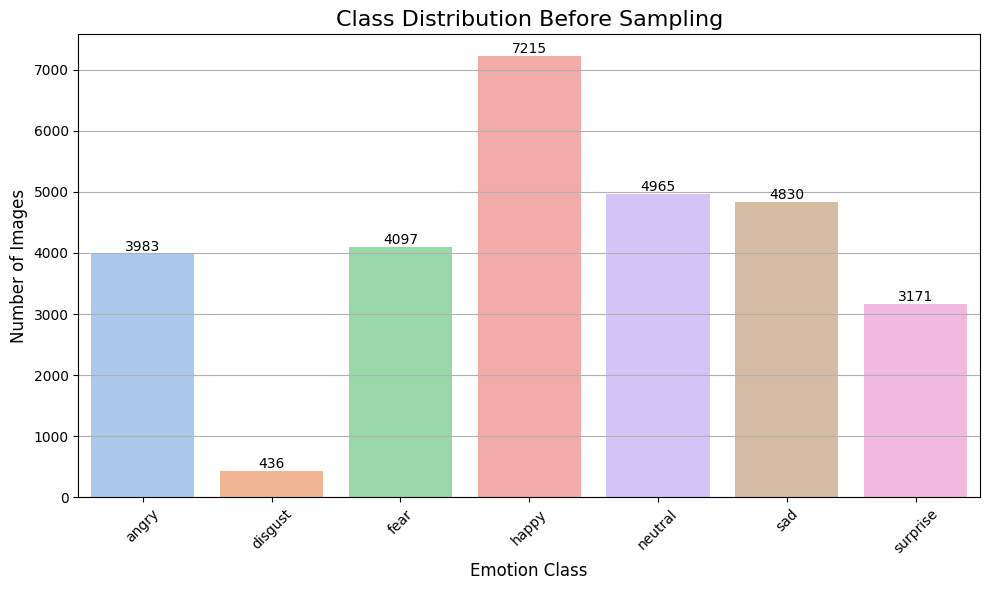

💾 Saved plot to /content/plots/class_distribution_before_sampling_percent.png


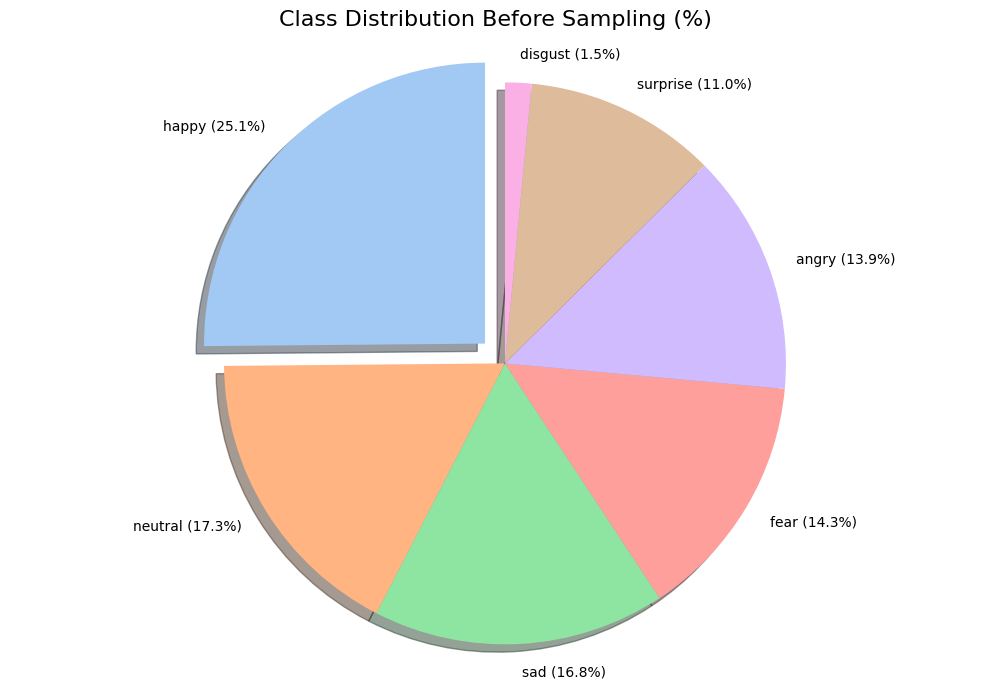


🔄 Balancing classes...

Choose a balancing strategy:
1. Mean (default) - Balance all classes to mean count
2. Min - Downsample all classes to minimum count
3. Max - Upsample all classes to maximum count
Enter choice (1-3) or press Enter for default: 1

🔧 Using mean strategy for balancing
📊 Current class distribution:
  angry: 3983
  disgust: 436
  fear: 4097
  happy: 7215
  neutral: 4965
  sad: 4830
  surprise: 3171
📦 Backing up original data to /content/train_original_backup...
✅ Backup complete!

🎯 Target class distribution (mean strategy):

🎯 Target class distribution (mean strategy):
  angry: 4099
  disgust: 4099
  fear: 4099
  happy: 4099
  neutral: 4099
  sad: 4099
  surprise: 4099

🔄 Balancing classes...
⬆️ Upsampling class: angry from 3983 to 4099 images
  ✓ Created 50/116 new images
  ✓ Created 100/116 new images
✅ Upsampling complete for angry
⬆️ Upsampling class: disgust from 436 to 4099 images
  ✓ Created 50/3663 new images
  ✓ Created 100/3663 new images
  ✓ Created 150/3

<ipython-input-1-fd58de938f26>:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=palette_name)


💾 Saved plot to /content/plots/class_distribution_after_sampling.png


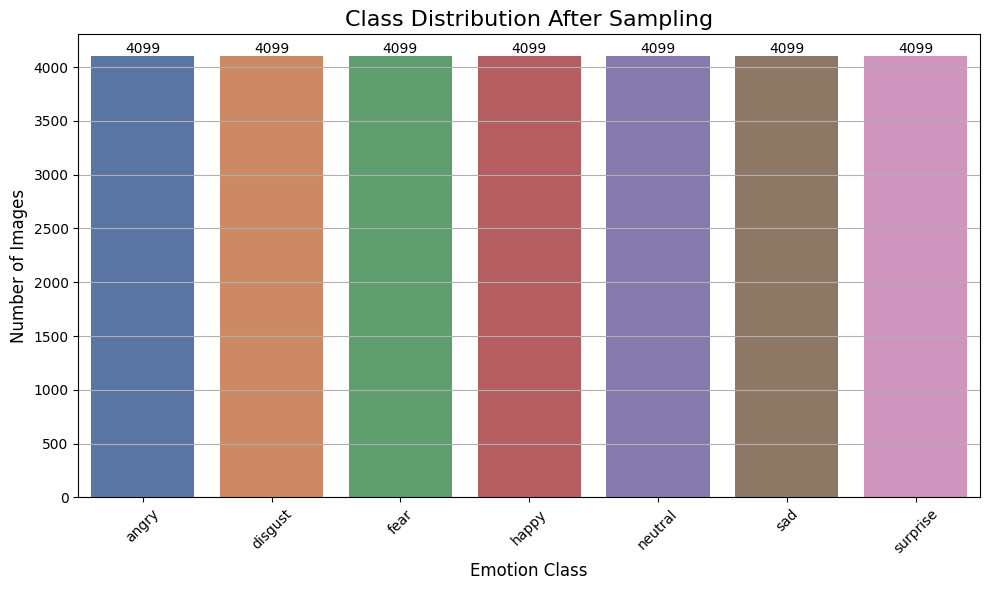

💾 Saved plot to /content/plots/class_distribution_after_sampling_percent.png


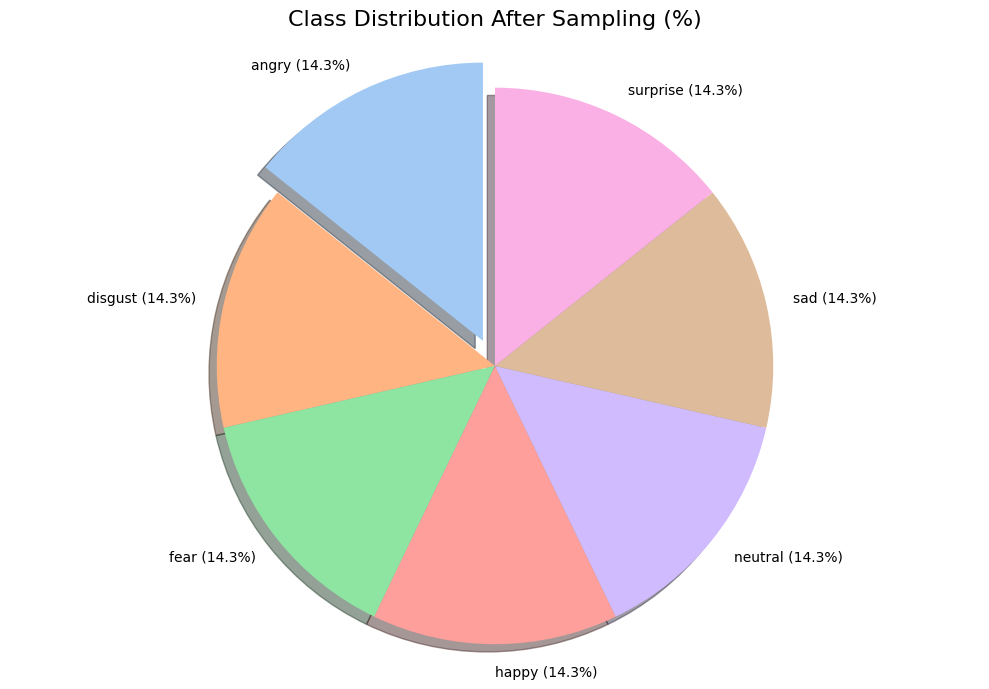


📊 Analyzing sampling impact:


<ipython-input-1-fd58de938f26>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=perc_change, palette=colors)


💾 Saved plot to /content/plots/percentage_change.png


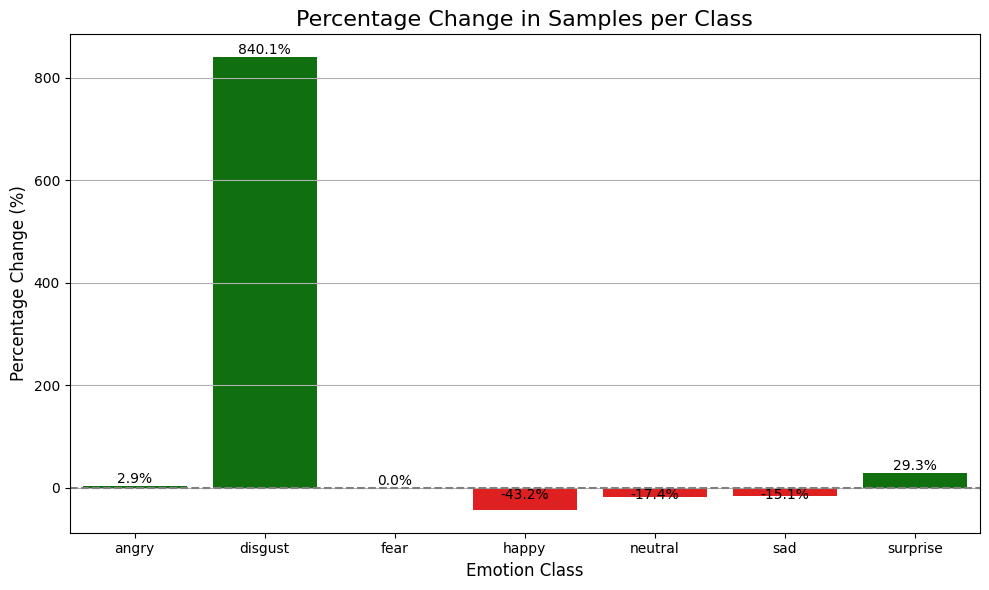

💾 Saved plot to /content/plots/class_imbalance_comparison.png


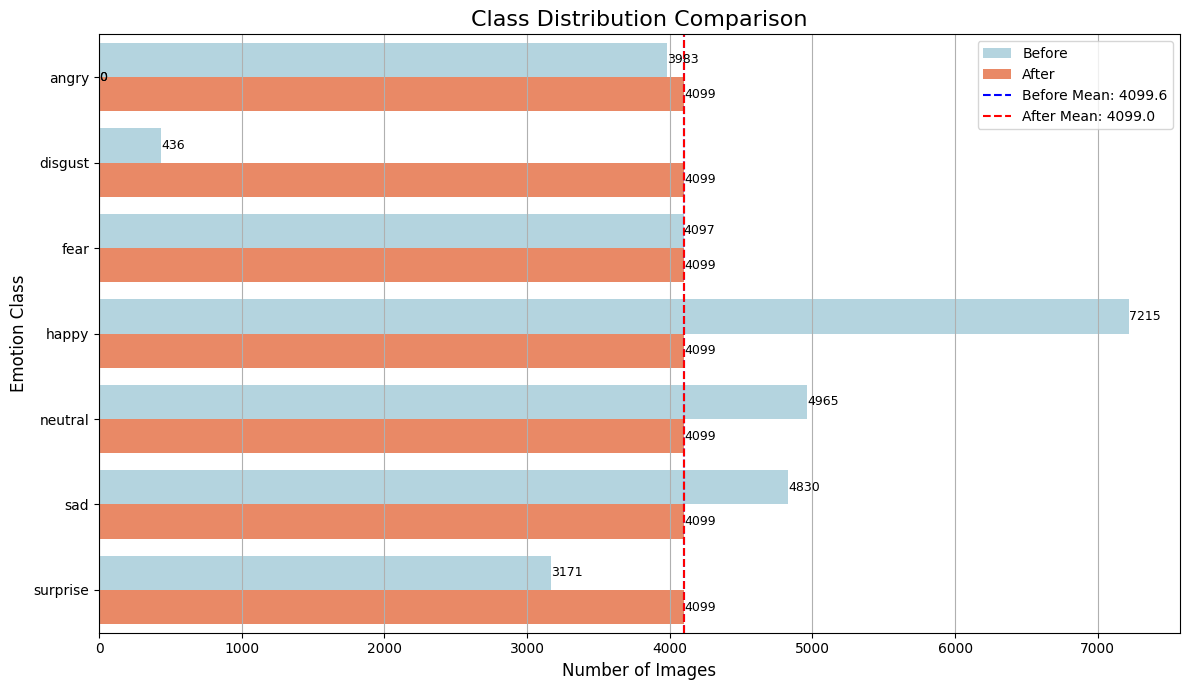

<ipython-input-1-fd58de938f26>:262: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
<ipython-input-1-fd58de938f26>:270: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Status', y='Total', data=totals_df, palette=['lightblue', 'coral'], ax=ax2)
<ipython-input-1-fd58de938f26>:281: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(before.keys()), y=before_percentages, palette='Blues', ax=ax3)
<ipython-input-1-fd58de938f26>:284: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

💾 Saved plot to /content/plots/sampling_impact_summary.png


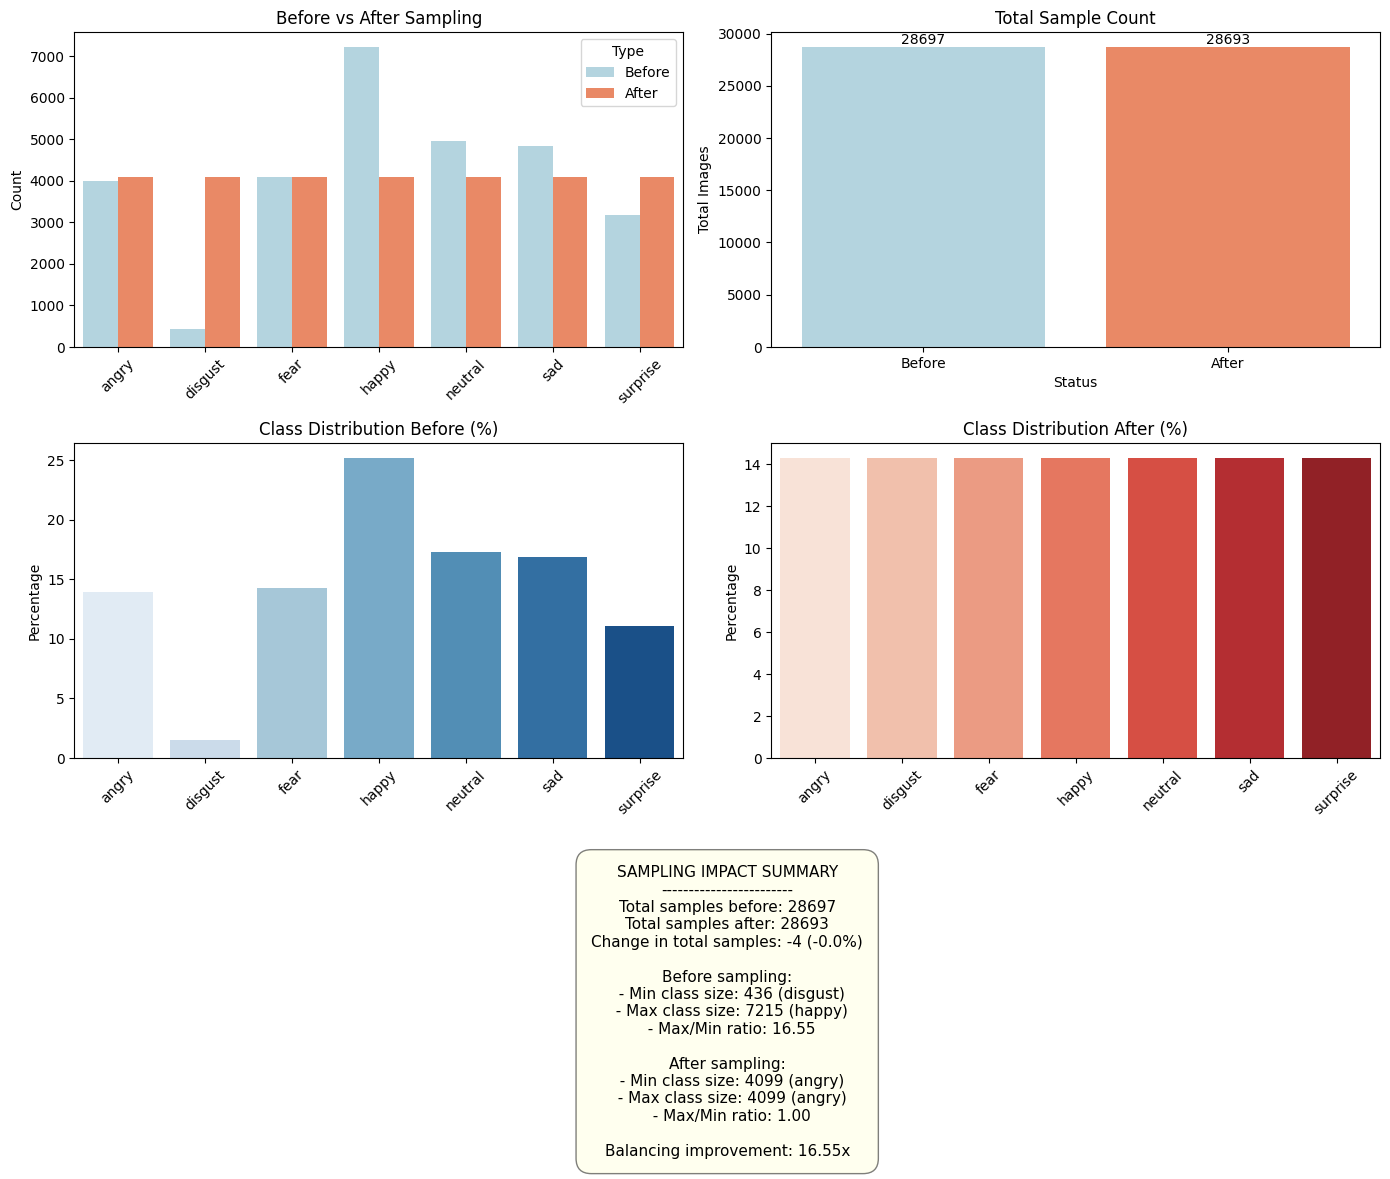


📑 Creating combined PDF report...


<ipython-input-1-fd58de938f26>:343: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(before_counts.keys()), y=list(before_counts.values()), palette="pastel")
<ipython-input-1-fd58de938f26>:355: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(after_counts.keys()), y=list(after_counts.values()), palette="deep")
<ipython-input-1-fd58de938f26>:413: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=perc_change, palette=colors)


📄 Created PDF report at /content/plots/class_balancing_report_mean.pdf

✅ Class balancing process complete!
📂 Individual plots saved to: /content/plots
📄 Combined PDF report saved to: /content/plots/class_balancing_report_mean.pdf

Summary:
- Initial class distribution: {'angry': 3983, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
- Final class distribution: {'angry': 4099, 'disgust': 4099, 'fear': 4099, 'happy': 4099, 'neutral': 4099, 'sad': 4099, 'surprise': 4099}
- Balancing strategy used: mean

🔍 You can view the saved plots in the plots directory:
   /content/plots


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib.gridspec import GridSpec
import zipfile
import shutil
import random
from PIL import Image

# Dataset paths
train_dir = "/content/train"
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Add a new directory for saving plots
plots_dir = "/content/plots"

# Create plots directory if it doesn't exist
def create_plots_directory():
    """Creates the directory for saving plots if it doesn't exist"""
    if not os.path.exists(plots_dir):
        print(f"📂 Creating plots directory: {plots_dir}")
        os.makedirs(plots_dir)

# 📦 Function to unzip dataset
def unzip_dataset(zip_path, extract_to="/content"):
    """
    Unzips a dataset archive file

    Parameters:
    zip_path (str): Path to the zip file
    extract_to (str): Directory to extract the zip file to

    Returns:
    bool: True if successful, False otherwise
    """
    try:
        print(f"📦 Extracting {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("✅ Extraction complete!")
        return True
    except Exception as e:
        print(f"❌ Error extracting zip file: {e}")
        return False

# 📂 Check and create train directory structure if needed
def setup_directory_structure():
    """
    Creates the train directory and class subdirectories if they don't exist
    """
    # Create main training directory if it doesn't exist
    if not os.path.exists(train_dir):
        print(f"📂 Creating main directory: {train_dir}")
        os.makedirs(train_dir)

    # Create subdirectories for each class if they don't exist
    for emotion_class in classes:
        class_dir = os.path.join(train_dir, emotion_class)
        if not os.path.exists(class_dir):
            print(f"📂 Creating directory for {emotion_class} class")
            os.makedirs(class_dir)

    # Create plots directory
    create_plots_directory()

# 📊 Function to count images per class
def get_class_distribution(directory):
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
        else:
            class_counts[class_name] = 0
    return class_counts

# 📊 Function to plot class distribution
def plot_distribution(class_counts, title="Class Distribution", palette_name="pastel", save=True):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=palette_name)
    plt.title(title, fontsize=16)
    plt.xlabel("Emotion Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Add count labels on top of each bar
    ax = plt.gca()
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'bottom', fontsize=10)

    plt.tight_layout()

    # Save the plot if requested
    if save:
        filename = title.replace(" ", "_").lower() + ".png"
        filepath = os.path.join(plots_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to {filepath}")

    plt.show()

# 📊 Function to plot pie chart of class distribution
def plot_pie_distribution(class_counts, title="Class Distribution (%)", save=True):
    plt.figure(figsize=(10, 7))
    total = sum(class_counts.values())
    percentages = {k: (v/total)*100 for k, v in class_counts.items()}

    # Sort wedges from largest to smallest
    sorted_items = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
    labels = [f"{k} ({v:.1f}%)" for k, v in sorted_items]
    values = [v for _, v in sorted_items]
    keys = [k for k, _ in sorted_items]

    # Use a colorful palette with an explode for the largest class
    explode = [0.1 if i == 0 else 0 for i in range(len(keys))]
    plt.pie(values, labels=labels, autopct='', explode=explode,
            shadow=True, startangle=90, colors=sns.color_palette('pastel', len(keys)))
    plt.title(title, fontsize=16)
    plt.axis('equal')
    plt.tight_layout()

    # Save the plot if requested
    if save:
        filename = title.replace(" ", "_").replace("(%)", "percent").lower() + ".png"
        filepath = os.path.join(plots_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to {filepath}")

    plt.show()

# 📉 Function to plot percentage change
def plot_percentage_change(before, after, save=True):
    plt.figure(figsize=(10, 6))
    before_values = np.array([before.get(c, 0) for c in classes])
    after_values = np.array([after.get(c, 0) for c in classes])

    # Calculate percentage change, handling zero values properly
    perc_change = np.zeros_like(before_values, dtype=float)
    for i in range(len(before_values)):
        if before_values[i] == 0:
            if after_values[i] == 0:
                perc_change[i] = 0  # No change if both are zero
            else:
                perc_change[i] = 100  # 100% increase if starting from zero
        else:
            perc_change[i] = ((after_values[i] - before_values[i]) / before_values[i]) * 100

    # Create a colormap based on the values
    colors = ['red' if x < 0 else 'green' for x in perc_change]

    sns.barplot(x=classes, y=perc_change, palette=colors)
    plt.title("Percentage Change in Samples per Class", fontsize=16)
    plt.ylabel("Percentage Change (%)", fontsize=12)
    plt.xlabel("Emotion Class", fontsize=12)
    plt.axhline(0, color='gray', linestyle='--')
    plt.grid(axis='y')

    # Add percentage labels on top of each bar
    ax = plt.gca()
    for i, p in enumerate(ax.patches):
        label = f"{perc_change[i]:.1f}%"
        ax.annotate(label,
                   (p.get_x() + p.get_width() / 2., p.get_height() if p.get_height() > 0 else 0),
                   ha = 'center', va = 'bottom' if p.get_height() > 0 else 'top',
                   fontsize=10)

    plt.tight_layout()

    # Save the plot if requested
    if save:
        filepath = os.path.join(plots_dir, "percentage_change.png")
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to {filepath}")

    plt.show()

# 📊 Function to plot class imbalance using horizontal bars
def plot_class_imbalance(before, after, save=True):
    plt.figure(figsize=(12, 7))

    # Calculate mean sample count before sampling
    before_values = np.array([before.get(c, 0) for c in classes])
    after_values = np.array([after.get(c, 0) for c in classes])
    before_mean = np.mean(before_values)
    after_mean = np.mean(after_values)

    # Create DataFrame for easier plotting
    df = pd.DataFrame({
        'Class': classes + classes,
        'Count': list(before_values) + list(after_values),
        'Type': ['Before']*len(classes) + ['After']*len(classes)
    })

    # Sort by class name so they line up
    df = df.sort_values(['Type', 'Class'], ascending=[False, True])

    # Plot
    ax = sns.barplot(x='Count', y='Class', hue='Type', data=df, palette=['lightblue', 'coral'])

    # Add vertical lines for mean values
    plt.axvline(x=before_mean, color='blue', linestyle='--', label=f'Before Mean: {before_mean:.1f}')
    plt.axvline(x=after_mean, color='red', linestyle='--', label=f'After Mean: {after_mean:.1f}')

    plt.title("Class Distribution Comparison", fontsize=16)
    plt.xlabel("Number of Images", fontsize=12)
    plt.ylabel("Emotion Class", fontsize=12)
    plt.grid(axis='x')
    plt.legend()

    # Add count labels on each bar
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_width())}',
                   (p.get_width(), p.get_y() + p.get_height()/2),
                   ha = 'left', va = 'center', fontsize=9)

    plt.tight_layout()

    # Save the plot if requested
    if save:
        filepath = os.path.join(plots_dir, "class_imbalance_comparison.png")
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to {filepath}")

    plt.show()

# 📊 Function to visualize overall sampling impact
def visualize_sampling_impact(before, after, save=True):
    # Create DataFrame
    before_df = pd.DataFrame({'Count': before.values(), 'Class': before.keys(), 'Type': 'Before'})
    after_df = pd.DataFrame({'Count': after.values(), 'Class': after.keys(), 'Type': 'After'})
    df = pd.concat([before_df, after_df])

    # Calculate summary statistics
    before_total = sum(before.values())
    after_total = sum(after.values())
    total_change = after_total - before_total
    percent_change = (total_change / before_total) * 100 if before_total > 0 else 0

    before_min = min(before.values())
    before_max = max(before.values())
    before_ratio = before_max / before_min if before_min > 0 else float('inf')

    after_min = min(after.values())
    after_max = max(after.values())
    after_ratio = after_max / after_min if after_min > 0 else float('inf')

    # Set up the figure with GridSpec
    fig = plt.figure(figsize=(14, 12))
    gs = GridSpec(3, 4, figure=fig)

    # Before/After Bar Chart (Top Left)
    ax1 = fig.add_subplot(gs[0, :2])
    sns.barplot(x='Class', y='Count', hue='Type', data=df, palette=['lightblue', 'coral'], ax=ax1)
    ax1.set_title('Before vs After Sampling', fontsize=12)
    ax1.set_xlabel('')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    # Total Sample Count (Top Right)
    ax2 = fig.add_subplot(gs[0, 2:])
    totals_df = pd.DataFrame({
        'Status': ['Before', 'After'],
        'Total': [before_total, after_total]
    })
    sns.barplot(x='Status', y='Total', data=totals_df, palette=['lightblue', 'coral'], ax=ax2)
    ax2.set_title('Total Sample Count', fontsize=12)
    ax2.set_ylabel('Total Images')
    for i, p in enumerate(ax2.patches):
        ax2.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width()/2, p.get_height()),
                   ha = 'center', va = 'bottom', fontsize=10)

    # Class Distribution Before (Middle Left)
    ax3 = fig.add_subplot(gs[1, :2])
    before_percentages = [count/before_total*100 for count in before.values()] if before_total > 0 else [0]*len(before)
    sns.barplot(x=list(before.keys()), y=before_percentages, palette='Blues', ax=ax3)
    ax3.set_title('Class Distribution Before (%)', fontsize=12)
    ax3.set_ylabel('Percentage')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

    # Class Distribution After (Middle Right)
    ax4 = fig.add_subplot(gs[1, 2:])
    after_percentages = [count/after_total*100 for count in after.values()] if after_total > 0 else [0]*len(after)
    sns.barplot(x=list(after.keys()), y=after_percentages, palette='Reds', ax=ax4)
    ax4.set_title('Class Distribution After (%)', fontsize=12)
    ax4.set_ylabel('Percentage')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)

    # Summary Information Text Box (Bottom)
    ax5 = fig.add_subplot(gs[2, 1:3])
    ax5.axis('off')
    summary_text = (
        f"SAMPLING IMPACT SUMMARY\n"
        f"------------------------\n"
        f"Total samples before: {before_total}\n"
        f"Total samples after: {after_total}\n"
        f"Change in total samples: {total_change:+} ({percent_change:.1f}%)\n\n"
        f"Before sampling:\n"
        f"  - Min class size: {before_min} ({min(before.items(), key=lambda x: x[1])[0]})\n"
        f"  - Max class size: {before_max} ({max(before.items(), key=lambda x: x[1])[0]})\n"
        f"  - Max/Min ratio: {before_ratio:.2f}\n\n"
        f"After sampling:\n"
        f"  - Min class size: {after_min} ({min(after.items(), key=lambda x: x[1])[0]})\n"
        f"  - Max class size: {after_max} ({max(after.items(), key=lambda x: x[1])[0]})\n"
        f"  - Max/Min ratio: {after_ratio:.2f}\n\n"
        f"Balancing improvement: {before_ratio/after_ratio:.2f}x"
    )
    ax5.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=11,
             bbox=dict(facecolor='lightyellow', alpha=0.5, boxstyle='round,pad=1'))

    plt.tight_layout()

    # Save the plot if requested
    if save:
        filepath = os.path.join(plots_dir, "sampling_impact_summary.png")
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to {filepath}")

    plt.show()

# 🧾 Function to save all plots to a PDF report
def save_plots_to_pdf(before_counts, after_counts, strategy="mean"):
    """
    Generate a PDF report with all plots

    Parameters:
    before_counts (dict): Dictionary with class counts before balancing
    after_counts (dict): Dictionary with class counts after balancing
    strategy (str): Balancing strategy used
    """
    from matplotlib.backends.backend_pdf import PdfPages

    pdf_path = os.path.join(plots_dir, f"class_balancing_report_{strategy}.pdf")

    with PdfPages(pdf_path) as pdf:
        # Plot 1: Distribution before
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(before_counts.keys()), y=list(before_counts.values()), palette="pastel")
        plt.title("Class Distribution Before Sampling", fontsize=16)
        plt.xlabel("Emotion Class", fontsize=12)
        plt.ylabel("Number of Images", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Plot 2: Distribution after
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(after_counts.keys()), y=list(after_counts.values()), palette="deep")
        plt.title("Class Distribution After Sampling", fontsize=16)
        plt.xlabel("Emotion Class", fontsize=12)
        plt.ylabel("Number of Images", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Plot 3: Pie before
        plt.figure(figsize=(10, 7))
        total = sum(before_counts.values())
        percentages = {k: (v/total)*100 for k, v in before_counts.items()}
        sorted_items = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
        labels = [f"{k} ({v:.1f}%)" for k, v in sorted_items]
        values = [v for _, v in sorted_items]
        keys = [k for k, _ in sorted_items]
        explode = [0.1 if i == 0 else 0 for i in range(len(keys))]
        plt.pie(values, labels=labels, autopct='', explode=explode,
                shadow=True, startangle=90, colors=sns.color_palette('pastel', len(keys)))
        plt.title("Class Distribution Before Sampling (%)", fontsize=16)
        plt.axis('equal')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Plot 4: Pie after
        plt.figure(figsize=(10, 7))
        total = sum(after_counts.values())
        percentages = {k: (v/total)*100 for k, v in after_counts.items()}
        sorted_items = sorted(percentages.items(), key=lambda x: x[1], reverse=True)
        labels = [f"{k} ({v:.1f}%)" for k, v in sorted_items]
        values = [v for _, v in sorted_items]
        keys = [k for k, _ in sorted_items]
        explode = [0.1 if i == 0 else 0 for i in range(len(keys))]
        plt.pie(values, labels=labels, autopct='', explode=explode,
                shadow=True, startangle=90, colors=sns.color_palette('pastel', len(keys)))
        plt.title("Class Distribution After Sampling (%)", fontsize=16)
        plt.axis('equal')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Plot 5: Percentage change
        plt.figure(figsize=(10, 6))
        before_values = np.array([before_counts.get(c, 0) for c in classes])
        after_values = np.array([after_counts.get(c, 0) for c in classes])
        perc_change = np.zeros_like(before_values, dtype=float)
        for i in range(len(before_values)):
            if before_values[i] == 0:
                if after_values[i] == 0:
                    perc_change[i] = 0
                else:
                    perc_change[i] = 100
            else:
                perc_change[i] = ((after_values[i] - before_values[i]) / before_values[i]) * 100
        colors = ['red' if x < 0 else 'green' for x in perc_change]
        sns.barplot(x=classes, y=perc_change, palette=colors)
        plt.title("Percentage Change in Samples per Class", fontsize=16)
        plt.ylabel("Percentage Change (%)", fontsize=12)
        plt.xlabel("Emotion Class", fontsize=12)
        plt.axhline(0, color='gray', linestyle='--')
        plt.grid(axis='y')
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Plot 6: Class imbalance
        plt.figure(figsize=(12, 7))
        before_values = np.array([before_counts.get(c, 0) for c in classes])
        after_values = np.array([after_counts.get(c, 0) for c in classes])
        before_mean = np.mean(before_values)
        after_mean = np.mean(after_values)
        df = pd.DataFrame({
            'Class': classes + classes,
            'Count': list(before_values) + list(after_values),
            'Type': ['Before']*len(classes) + ['After']*len(classes)
        })
        df = df.sort_values(['Type', 'Class'], ascending=[False, True])
        ax = sns.barplot(x='Count', y='Class', hue='Type', data=df, palette=['lightblue', 'coral'])
        plt.axvline(x=before_mean, color='blue', linestyle='--', label=f'Before Mean: {before_mean:.1f}')
        plt.axvline(x=after_mean, color='red', linestyle='--', label=f'After Mean: {after_mean:.1f}')
        plt.title("Class Distribution Comparison", fontsize=16)
        plt.xlabel("Number of Images", fontsize=12)
        plt.ylabel("Emotion Class", fontsize=12)
        plt.grid(axis='x')
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Plot 7: Sampling impact
        # This is more complex due to GridSpec, we'll simplify it
        fig = plt.figure(figsize=(14, 10))

        # Add title page with sampling strategy used
        plt.figtext(0.5, 0.5, f"Class Balancing Report\nStrategy: {strategy}",
                   ha='center', va='center', fontsize=20)
        plt.axis('off')
        pdf.savefig()
        plt.close()

    print(f"📄 Created PDF report at {pdf_path}")

# 🔄 Function to backup original data (important before modifying)
def backup_original_data(backup_dir="/content/train_original_backup"):
    """Backs up the original training data before sampling"""
    if os.path.exists(backup_dir):
        print(f"⚠️ Backup directory already exists at {backup_dir}")
        overwrite = input("Do you want to overwrite it? (y/n): ")
        if overwrite.lower() != 'y':
            print("❌ Backup operation cancelled.")
            return False

    # Remove existing backup if it exists
    if os.path.exists(backup_dir):
        shutil.rmtree(backup_dir)

    # Create fresh backup
    print(f"📦 Backing up original data to {backup_dir}...")
    shutil.copytree(train_dir, backup_dir)
    print("✅ Backup complete!")
    return True

# 📊 Function to calculate target counts for each class
def calculate_target_counts(class_counts, strategy="mean"):
    """
    Calculate target sample counts for balancing classes

    Parameters:
    class_counts (dict): Dictionary with class names as keys and counts as values
    strategy (str): 'mean' (default) - all classes will have mean count
                   'min' - all classes will have min count (undersampling only)
                   'max' - all classes will have max count (oversampling only)

    Returns:
    dict: Dictionary with class names as keys and target counts as values
    """
    if strategy == "mean":
        target_count = int(np.mean(list(class_counts.values())))
    elif strategy == "min":
        target_count = min(class_counts.values())
    elif strategy == "max":
        target_count = max(class_counts.values())
    else:
        raise ValueError("Strategy must be one of 'mean', 'min', or 'max'")

    return {class_name: target_count for class_name in class_counts.keys()}

# 🔄 Function to perform upsampling through image duplication and augmentation
def upsample_class(class_dir, current_count, target_count):
    """
    Upsample a class by duplicating and augmenting images until target count is reached

    Parameters:
    class_dir (str): Directory containing the class images
    current_count (int): Current number of images in the class
    target_count (int): Target number of images for the class
    """
    print(f"⬆️ Upsampling class: {os.path.basename(class_dir)} from {current_count} to {target_count} images")

    if current_count == 0:
        print(f"⚠️ No images in {class_dir} to upsample!")
        return

    # Get list of original images
    orig_images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]

    # How many more images we need to create
    num_to_create = target_count - current_count

    # Simple augmentation functions
    augmentations = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),  # Horizontal flip
        lambda img: img.rotate(10),  # Rotate slightly right
        lambda img: img.rotate(-10),  # Rotate slightly left
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),  # Vertical flip
        lambda img: img.rotate(180),  # 180 degree rotation
    ]

    created = 0
    aug_index = 0

    while created < num_to_create:
        # Pick a random original image
        img_path = random.choice(orig_images)
        img_name = os.path.basename(img_path)
        base_name, ext = os.path.splitext(img_name)

        try:
            # Open image
            img = Image.open(img_path)

            # Apply augmentation
            aug_func = augmentations[aug_index % len(augmentations)]
            aug_img = aug_func(img)

            # Save augmented image
            new_name = f"{base_name}_aug_{created}{ext}"
            aug_img.save(os.path.join(class_dir, new_name))

            created += 1
            aug_index += 1

            if created % 50 == 0:
                print(f"  ✓ Created {created}/{num_to_create} new images")

        except Exception as e:
            print(f"  ✗ Error processing {img_path}: {e}")

    print(f"✅ Upsampling complete for {os.path.basename(class_dir)}")

# 🔄 Function to perform downsampling through random selection
def downsample_class(class_dir, current_count, target_count):
    """
    Downsample a class by randomly removing images until target count is reached

    Parameters:
    class_dir (str): Directory containing the class images
    current_count (int): Current number of images in the class
    target_count (int): Target number of images for the class
    """
    print(f"⬇️ Downsampling class: {os.path.basename(class_dir)} from {current_count} to {target_count} images")

    if current_count <= target_count:
        print(f"⚠️ Current count {current_count} is already <= target {target_count}. No downsampling needed.")
        return

    # Get all images
    all_images = os.listdir(class_dir)

    # Calculate how many to remove
    num_to_remove = current_count - target_count

    # Randomly select images to remove
    to_remove = random.sample(all_images, num_to_remove)

    # Remove selected images
    removed = 0
    for img_name in to_remove:
        try:
            os.remove(os.path.join(class_dir, img_name))
            removed += 1

            if removed % 50 == 0:
                print(f"  ✓ Removed {removed}/{num_to_remove} images")

        except Exception as e:
            print(f"  ✗ Error removing {img_name}: {e}")

    print(f"✅ Downsampling complete for {os.path.basename(class_dir)}")

# 🔄 Function to balance all classes
def balance_classes(train_directory, strategy="mean", backup=True):
    """
    Balance all classes in the dataset through upsampling and downsampling

    Parameters:
    train_directory (str): Directory containing the class subdirectories
    strategy (str): 'mean' (default) - all classes will have mean count
                   'min' - all classes will have min count (undersampling only)
                   'max' - all classes will have max count (oversampling only)
    backup (bool): Whether to backup original data before balancing

    Returns:
    tuple: (Original class counts dict, Balanced class counts dict)
    """
    # Get current class distribution
    class_counts = get_class_distribution(train_directory)
    print(f"📊 Current class distribution:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count}")

    # Backup original data if requested
    if backup:
        backup_original_data()

    # Calculate target counts
    target_counts = calculate_target_counts(class_counts, strategy)
    print(f"\n🎯 Target class distribution ({strategy} strategy):")
    # Calculate target counts
    target_counts = calculate_target_counts(class_counts, strategy)
    print(f"\n🎯 Target class distribution ({strategy} strategy):")
    for class_name, count in target_counts.items():
        print(f"  {class_name}: {count}")

    # Perform sampling for each class
    print("\n🔄 Balancing classes...")
    for class_name in classes:
        class_dir = os.path.join(train_directory, class_name)
        current_count = class_counts.get(class_name, 0)
        target_count = target_counts.get(class_name, 0)

        if current_count < target_count:
            # Upsample
            upsample_class(class_dir, current_count, target_count)
        elif current_count > target_count:
            # Downsample
            downsample_class(class_dir, current_count, target_count)
        else:
            print(f"✅ Class {class_name} already has target count of {target_count}")

    # Get new class distribution
    new_class_counts = get_class_distribution(train_directory)
    print(f"\n📊 New class distribution:")
    for class_name, count in new_class_counts.items():
        print(f"  {class_name}: {count}")

    return class_counts, new_class_counts

# Main execution block
if __name__ == "__main__":
    # Step 0: Unzip dataset if needed
    # Check if the zip file exists - assuming it's named "train.zip" in the content directory
    zip_file_path = "/content/train.zip"
    if os.path.exists(zip_file_path):
        print("🔍 Found zip file. Extracting dataset...")
        unzip_dataset(zip_file_path)
    else:
        print("⚠️ No zip file found at /content/train.zip")
        # Check if there are any zip files in the content directory
        content_files = os.listdir("/content")
        zip_files = [f for f in content_files if f.endswith('.zip')]
        if zip_files:
            print(f"📦 Found these zip files: {zip_files}")
            for zip_file in zip_files:
                user_input = input(f"🤔 Do you want to extract {zip_file}? (y/n): ")
                if user_input.lower() == 'y':
                    unzip_dataset(os.path.join("/content", zip_file))
        else:
            print("❌ No zip files found in /content directory")

    # Ensure directory structure exists
    setup_directory_structure()

    # 🧾 Step 1: BEFORE Sampling
    print("\n📍 Before Sampling:")
    before_counts = get_class_distribution(train_dir)
    plot_distribution(before_counts, title="Class Distribution Before Sampling", palette_name="pastel")
    plot_pie_distribution(before_counts, title="Class Distribution Before Sampling (%)")

    # 🔁 Step 2: Run balancing (upsampling/downsampling)
    print("\n🔄 Balancing classes...")
    # Ask user for balancing strategy
    print("\nChoose a balancing strategy:")
    print("1. Mean (default) - Balance all classes to mean count")
    print("2. Min - Downsample all classes to minimum count")
    print("3. Max - Upsample all classes to maximum count")
    strategy_choice = input("Enter choice (1-3) or press Enter for default: ")

    if strategy_choice == "2":
        strategy = "min"
    elif strategy_choice == "3":
        strategy = "max"
    else:
        strategy = "mean"  # Default

    print(f"\n🔧 Using {strategy} strategy for balancing")

    # Perform balancing
    before_counts, after_counts = balance_classes(train_dir, strategy=strategy)

    # 🧾 Step 3: AFTER Sampling
    print("\n📍 After Sampling:")
    plot_distribution(after_counts, title="Class Distribution After Sampling", palette_name="deep")
    plot_pie_distribution(after_counts, title="Class Distribution After Sampling (%)")

    # Step 4: Analysis visualizations
    print("\n📊 Analyzing sampling impact:")
    plot_percentage_change(before_counts, after_counts)
    plot_class_imbalance(before_counts, after_counts)
    visualize_sampling_impact(before_counts, after_counts)

    # Step 5: Save all plots to a combined PDF report
    print("\n📑 Creating combined PDF report...")
    save_plots_to_pdf(before_counts, after_counts, strategy)

    # Step 6: Display final summary
    print("\n✅ Class balancing process complete!")
    print(f"📂 Individual plots saved to: {plots_dir}")
    print(f"📄 Combined PDF report saved to: {os.path.join(plots_dir, f'class_balancing_report_{strategy}.pdf')}")
    print("\nSummary:")
    print(f"- Initial class distribution: {before_counts}")
    print(f"- Final class distribution: {after_counts}")
    print(f"- Balancing strategy used: {strategy}")

    # Ask if user wants to view the saved plots directory
    print("\n🔍 You can view the saved plots in the plots directory:")
    print(f"   {plots_dir}")

In [ ]:
print("Before Counts:", before_counts)
print("After Counts:", after_counts)


Before Counts: {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}
After Counts: {'angry': 0, 'disgust': 0, 'fear': 0, 'happy': 0, 'neutral': 0, 'sad': 0, 'surprise': 0}


test_images/test_images folder already exists. Skipping unzip.
Loading model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model loaded successfully!
Processing images from test_images/test_images...


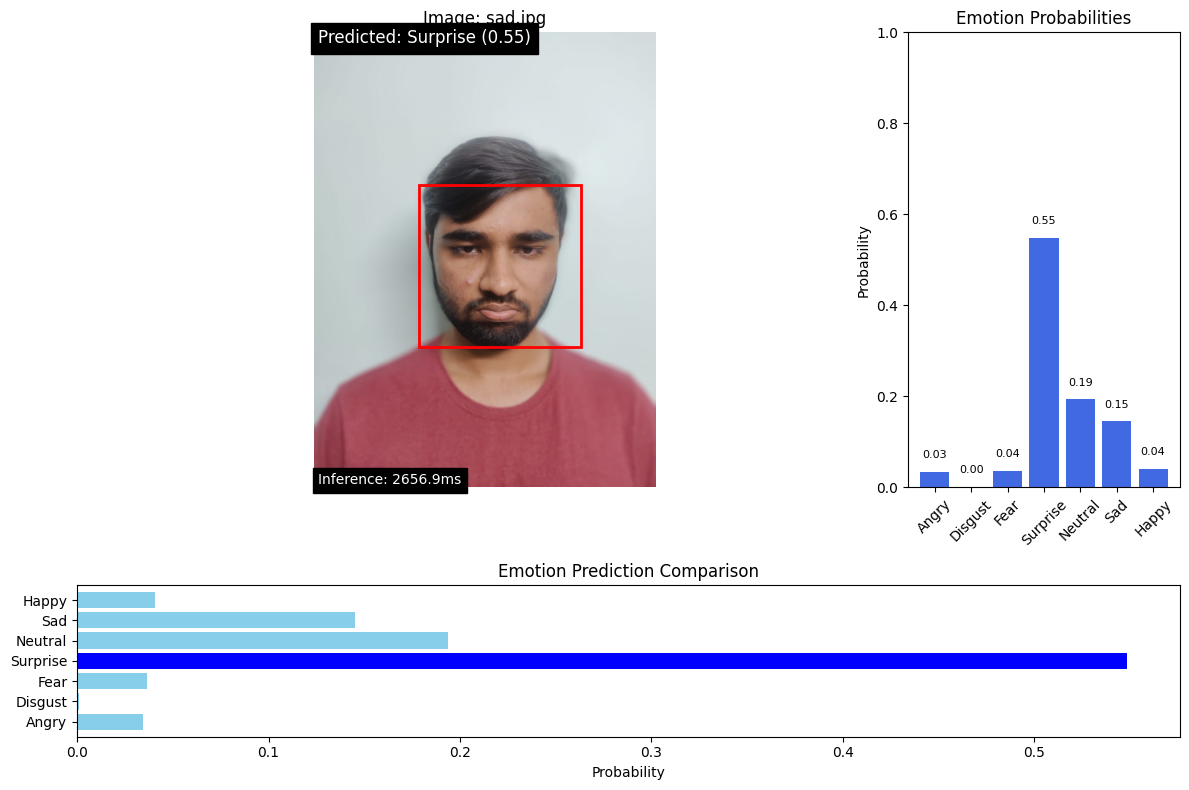

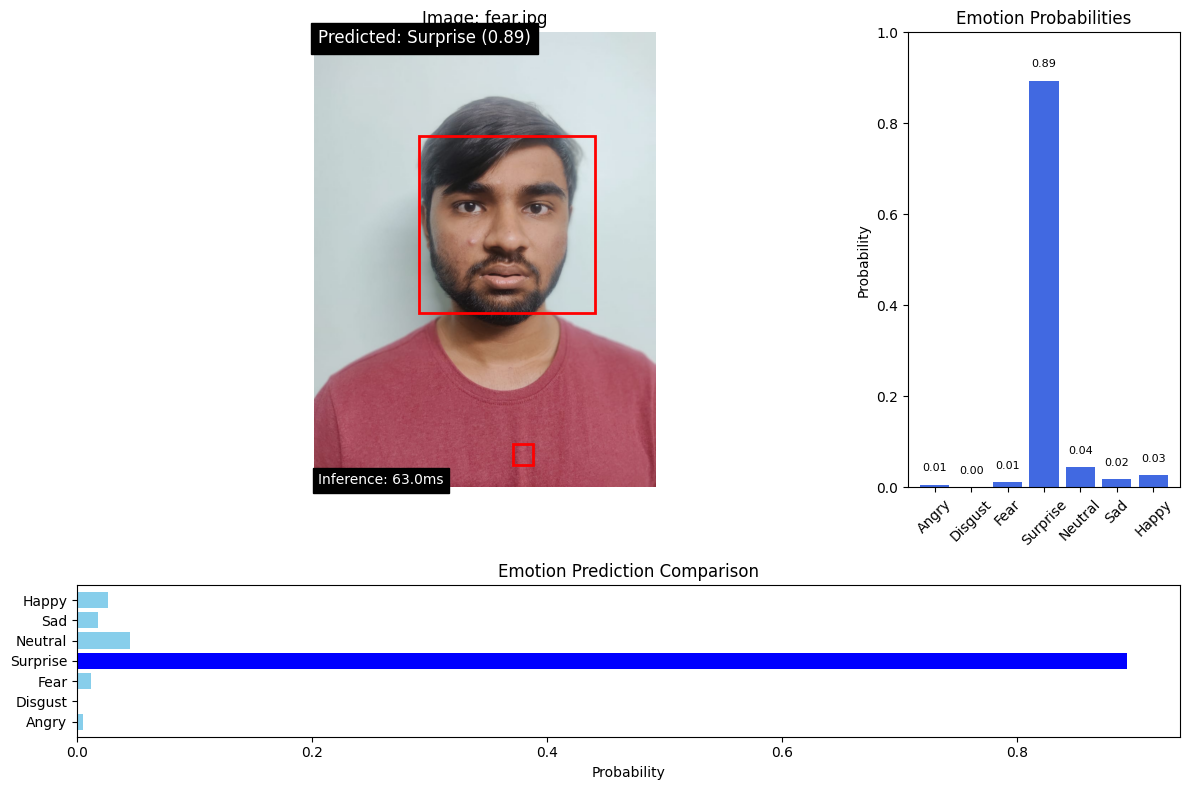

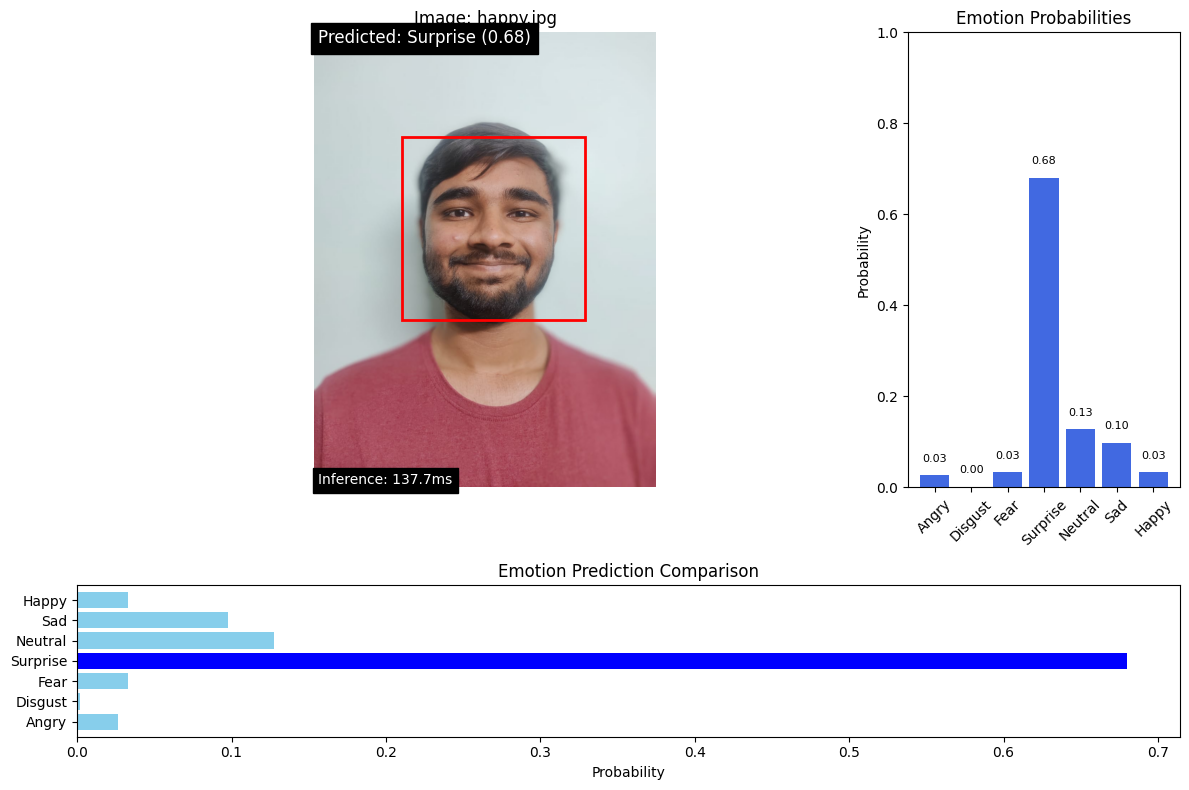

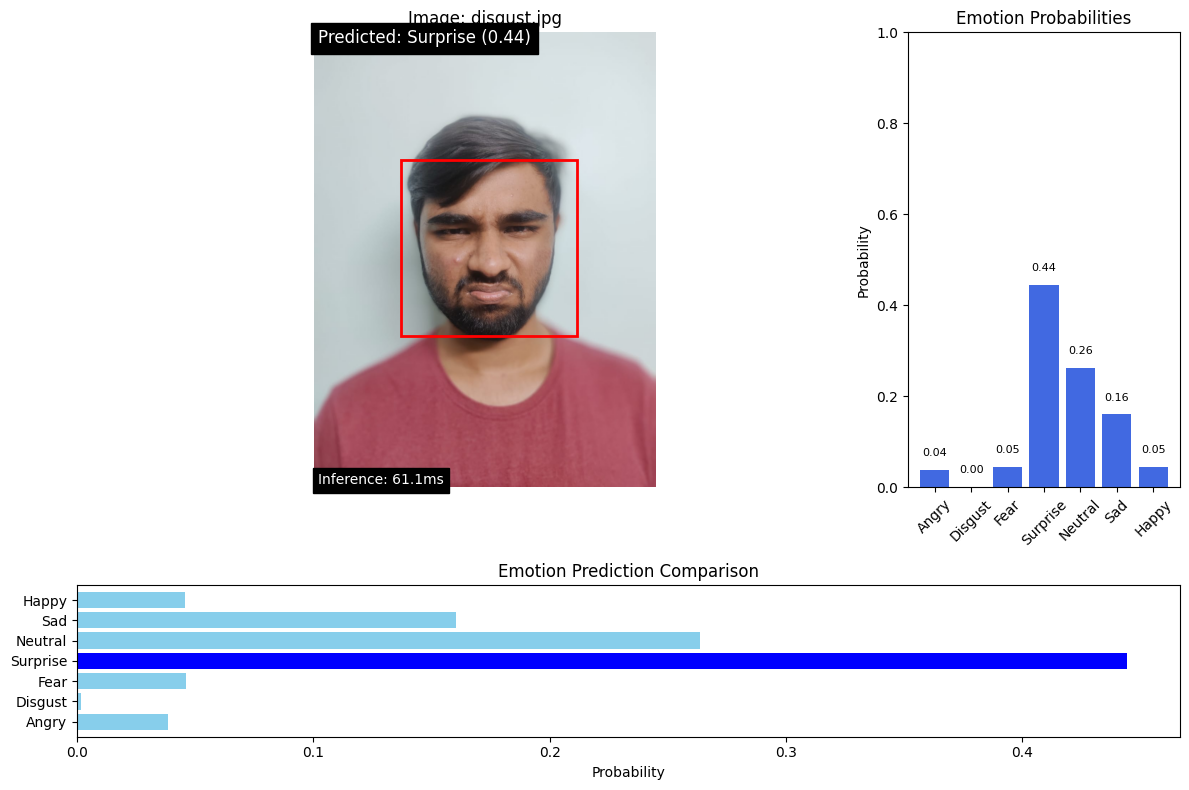

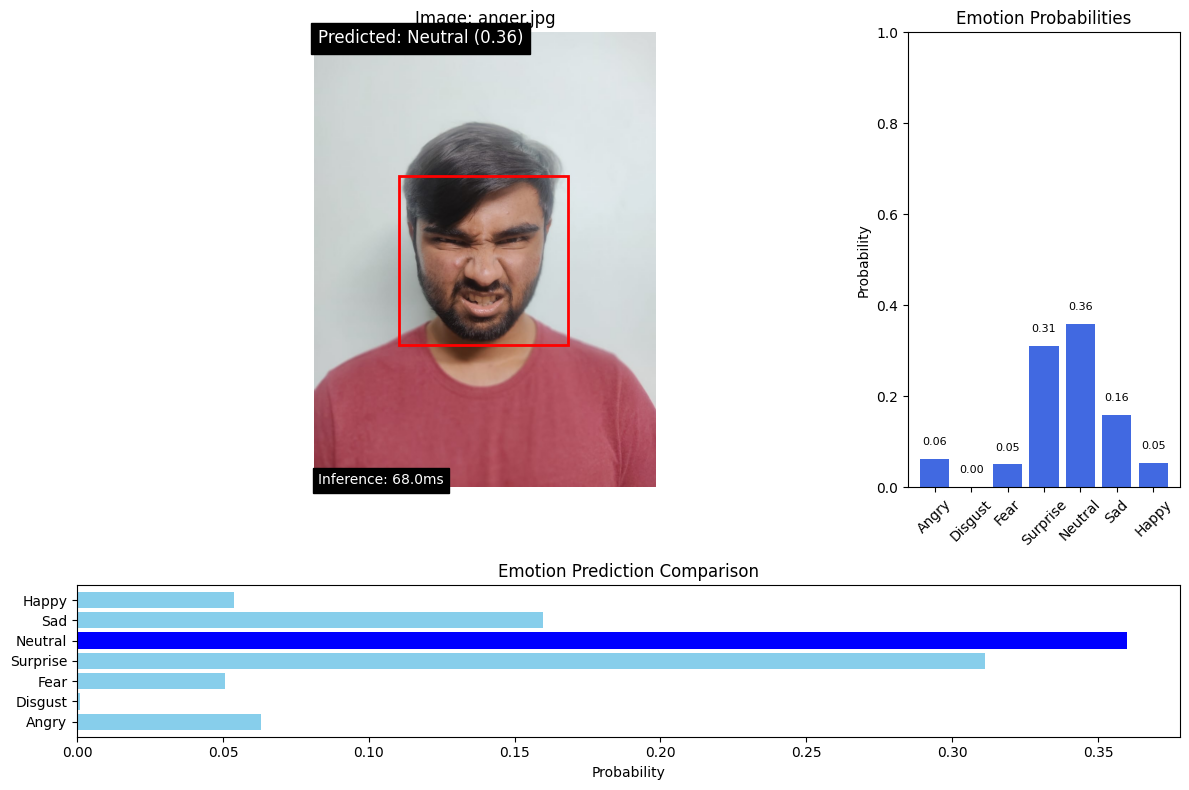

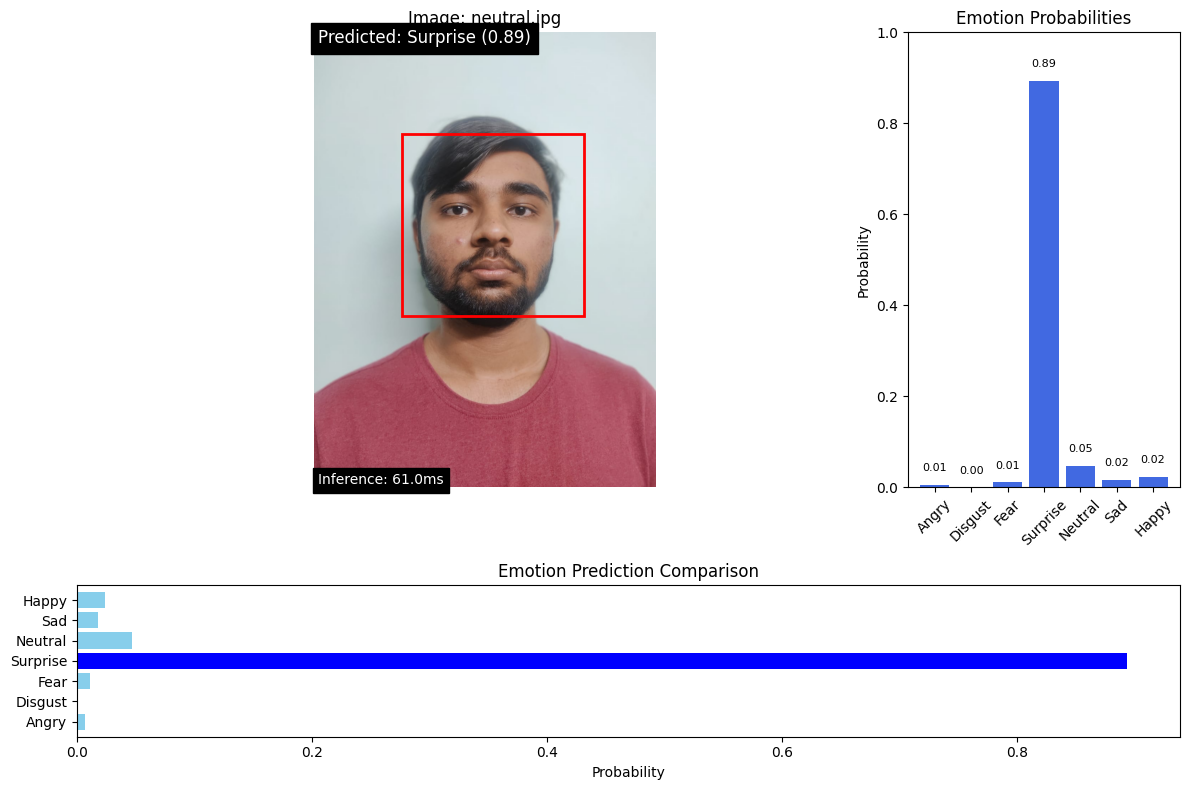

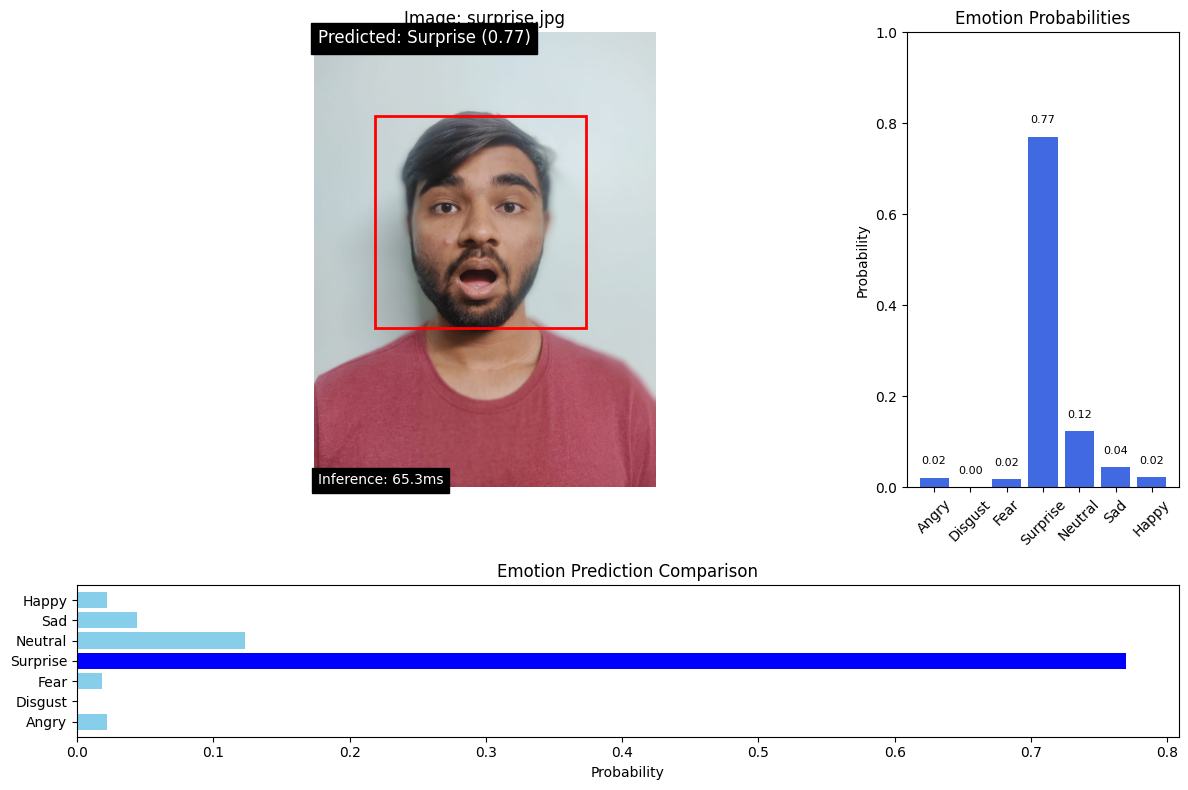

Processing complete! All visualizations saved to: fer_visualizations


In [ ]:
# Real-time FER2013 Image Prediction Script
# This script takes images from a folder, predicts emotions using a pre-trained model,
# and displays results with color-coded bounding boxes (green for correct, red for incorrect)

import os
import cv2
import numpy as np
import time
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import zipfile
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Define the emotion labels for FER2013
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


def load_and_preprocess_image(image_path, target_size=(48, 48)):
    """Load and preprocess an image for the FER2013 model"""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None, None

    # Convert to grayscale if it's a color image
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img.copy()

    # Store original image for display
    display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize grayscale image for model input
    resized_img = cv2.resize(gray_img, target_size)

    # Normalize pixel values
    normalized_img = resized_img / 255.0

    # Reshape for model input
    # FIXED: Convert grayscale to RGB by duplicating the channel three times
    model_input = np.stack([normalized_img, normalized_img, normalized_img], axis=-1)
    model_input = np.expand_dims(model_input, axis=0)  # Add batch dimension

    return model_input, display_img

def detect_face(img):
    """Detect face in image and return the face region"""
    # Convert to grayscale if it's not
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Load the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    return faces

def get_true_label_from_filename(filename):
    """Extract the true label from filename if available"""
    # Assume filename format contains label like "emotion_0_angry.jpg"
    # or folders are named after labels

    # Example: If filename contains the emotion label number
    for i in range(7):
        if f"_{i}_" in filename or f"emotion_{i}" in filename:
            return i

    # If no label found in filename, return None
    return None

def visualize_prediction_probabilities(pred_probs, ax):
    """Create a bar chart of prediction probabilities"""
    emotions = list(emotion_labels.values())
    ax.bar(emotions, pred_probs, color='royalblue')
    ax.set_ylabel('Probability')
    ax.set_title('Emotion Probabilities')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    for i, v in enumerate(pred_probs):
        ax.text(i, v+0.03, f"{v:.2f}", ha='center', fontsize=8)

def predict_and_display(image_folder, model, output_folder='output_visualizations', delay=1):
    """Process all images in a folder, predict emotions, and display results"""
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {image_folder}")
        return

    correct_count = 0
    total_count = 0
    all_predictions = []
    all_true_labels = []
    inference_times = []

    for img_idx, img_file in enumerate(image_files):
        img_path = os.path.join(image_folder, img_file)

        # Load and preprocess the image
        model_input, display_img = load_and_preprocess_image(img_path)
        if model_input is None:
            print(f"Could not load image: {img_path}")
            continue

        # Get the true label if available from filename or folder structure
        true_label = get_true_label_from_filename(img_file)
        if true_label is not None:
            all_true_labels.append(true_label)

        # Make prediction
        start_time = time.time()
        pred_probs = model.predict(model_input, verbose=0)[0]
        pred_label = np.argmax(pred_probs)
        inference_time = time.time() - start_time
        inference_times.append(inference_time)

        all_predictions.append(pred_label)

        # Create figure with subplots for enhanced visualization
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1])

        # Main image display
        ax_img = plt.subplot(gs[0, 0])
        ax_img.imshow(display_img)
        ax_img.set_title(f"Image: {img_file}")
        ax_img.axis('off')

        # Probabilities bar chart
        ax_prob = plt.subplot(gs[0, 1])
        visualize_prediction_probabilities(pred_probs, ax_prob)

        # Detect face
        faces = detect_face(display_img)

        # Determine if prediction is correct
        is_correct = (true_label is not None and pred_label == true_label)
        box_color = 'green' if is_correct else 'red'

        if true_label is not None:
            total_count += 1
            if is_correct:
                correct_count += 1

        # Draw bounding boxes and prediction info
        for (x, y, w, h) in faces:
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=box_color, facecolor='none')
            ax_img.add_patch(rect)

        # If no faces detected, draw box around the whole image
        if len(faces) == 0:
            rect = Rectangle((0, 0), display_img.shape[1], display_img.shape[0],
                           linewidth=2, edgecolor=box_color, facecolor='none')
            ax_img.add_patch(rect)

        # Add text with prediction info
        pred_text = f"Predicted: {emotion_labels[pred_label]} ({pred_probs[pred_label]:.2f})"
        ax_img.text(10, 30, pred_text, color='white', backgroundcolor='black', fontsize=12)

        if true_label is not None:
            true_text = f"True: {emotion_labels[true_label]}"
            result_text = "CORRECT" if is_correct else "WRONG"
            ax_img.text(10, 60, true_text, color='white', backgroundcolor='black', fontsize=12)
            ax_img.text(10, 90, result_text, color='green' if is_correct else 'red',
                   backgroundcolor='black', fontsize=12)

        # Add inference time
        ax_img.text(10, display_img.shape[0] - 10, f"Inference: {inference_time*1000:.1f}ms",
               color='white', backgroundcolor='black', fontsize=10)

        # Emotion comparison subplot (horizontal bar)
        ax_compare = plt.subplot(gs[1, :])

        emotions = list(emotion_labels.values())
        y_pos = np.arange(len(emotions))

        # Create horizontal bars for all emotions
        ax_compare.barh(y_pos, pred_probs, color='skyblue')

        # Highlight the predicted and true emotions
        ax_compare.barh(pred_label, pred_probs[pred_label], color='blue')

        if true_label is not None:
            # Add a marker for the true label
            ax_compare.plot(pred_probs[true_label], true_label, 'ro', markersize=10)

        ax_compare.set_yticks(y_pos)
        ax_compare.set_yticklabels(emotions)
        ax_compare.set_xlabel('Probability')
        ax_compare.set_title('Emotion Prediction Comparison')

        plt.tight_layout()

        # Save the visualization
        output_path = os.path.join(output_folder, f"prediction_{img_idx:03d}_{emotion_labels[pred_label]}.png")
        plt.savefig(output_path, dpi=150, bbox_inches='tight')

        # Display image
        plt.show()
        plt.pause(delay)  # Pause to allow viewing before moving to next image
        plt.close()

    # Generate summary visualizations
    if total_count > 0:
        accuracy = correct_count / total_count
        print(f"\nProcessed {total_count} images with ground truth labels")
        print(f"Correct predictions: {correct_count}")
        print(f"Accuracy: {accuracy:.2%}")

        # Create and save confusion matrix
        if len(all_true_labels) > 0:
            create_confusion_matrix(all_true_labels, all_predictions, output_folder)

        # Create and save inference time analysis
        create_inference_time_plot(inference_times, output_folder)

        # Create emotion distribution plot
        create_emotion_distribution_plot(all_true_labels, all_predictions, output_folder)

def create_confusion_matrix(true_labels, pred_labels, output_folder):
    """Create and save a confusion matrix visualization"""
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Create a dataframe for better visualization
    cm_df = pd.DataFrame(cm,
                        index=[emotion_labels[i] for i in range(len(emotion_labels))],
                        columns=[emotion_labels[i] for i in range(len(emotion_labels))])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Emotion')
    plt.xlabel('Predicted Emotion')

    # Save the confusion matrix
    plt.savefig(os.path.join(output_folder, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.close()

def create_inference_time_plot(inference_times, output_folder):
    """Create and save a plot of inference times"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(inference_times)), [t * 1000 for t in inference_times], 'b-')
    plt.xlabel('Image Number')
    plt.ylabel('Inference Time (ms)')
    plt.title('Model Inference Time per Image')
    plt.grid(True, alpha=0.3)

    # Add statistics
    avg_time = np.mean(inference_times) * 1000
    plt.axhline(y=avg_time, color='r', linestyle='--')
    plt.text(len(inference_times)/2, avg_time*1.1, f'Avg: {avg_time:.2f}ms',
             color='r', fontsize=12)

    plt.savefig(os.path.join(output_folder, 'inference_times.png'), dpi=150, bbox_inches='tight')
    plt.close()

def create_emotion_distribution_plot(true_labels, pred_labels, output_folder):
    """Create and save comparison of true vs predicted emotion distributions"""
    # Count occurrences of each emotion
    true_counts = [true_labels.count(i) for i in range(len(emotion_labels))]
    pred_counts = [pred_labels.count(i) for i in range(len(emotion_labels))]

    # Create a bar chart comparing distributions
    emotions = list(emotion_labels.values())
    x = np.arange(len(emotions))
    width = 0.35

    plt.figure(figsize=(12, 8))
    plt.bar(x - width/2, true_counts, width, label='True', color='skyblue')
    plt.bar(x + width/2, pred_counts, width, label='Predicted', color='salmon')

    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.title('Distribution of True vs Predicted Emotions')
    plt.xticks(x, emotions, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'emotion_distribution.png'), dpi=150, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    # Configuration - update these paths as needed
    model_path = '/content/CNN.h5'
    zip_path = '/content/test_images.zip'  # Zip file containing test images
    image_folder = 'test_images/test_images'  # Folder to extract and read images from
    output_folder = 'fer_visualizations'  # Folder to save visualizations

    # Unzip the test_images.zip file
    if not os.path.exists(image_folder):
        print(f"Unzipping {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('test_images')
        print("Unzipping complete!")
    else:
        print(f"{image_folder} folder already exists. Skipping unzip.")

    # Load the model
    print("Loading model...")
    model = load_model(model_path)
    print("Model loaded successfully!")

    # Run predictions with enhanced visualizations
    print(f"Processing images from {image_folder}...")
    predict_and_display(image_folder, model, output_folder, delay=2)

    print("Processing complete! All visualizations saved to:", output_folder)

<ipython-input-3-66c04749f835>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metric, y="Emotion", data=df, palette="viridis", ax=ax)
<ipython-input-3-66c04749f835>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metric, y="Emotion", data=df, palette="viridis", ax=ax)
<ipython-input-3-66c04749f835>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metric, y="Emotion", data=df, palette="viridis", ax=ax)
<ipython-input-3-66c04749f835>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

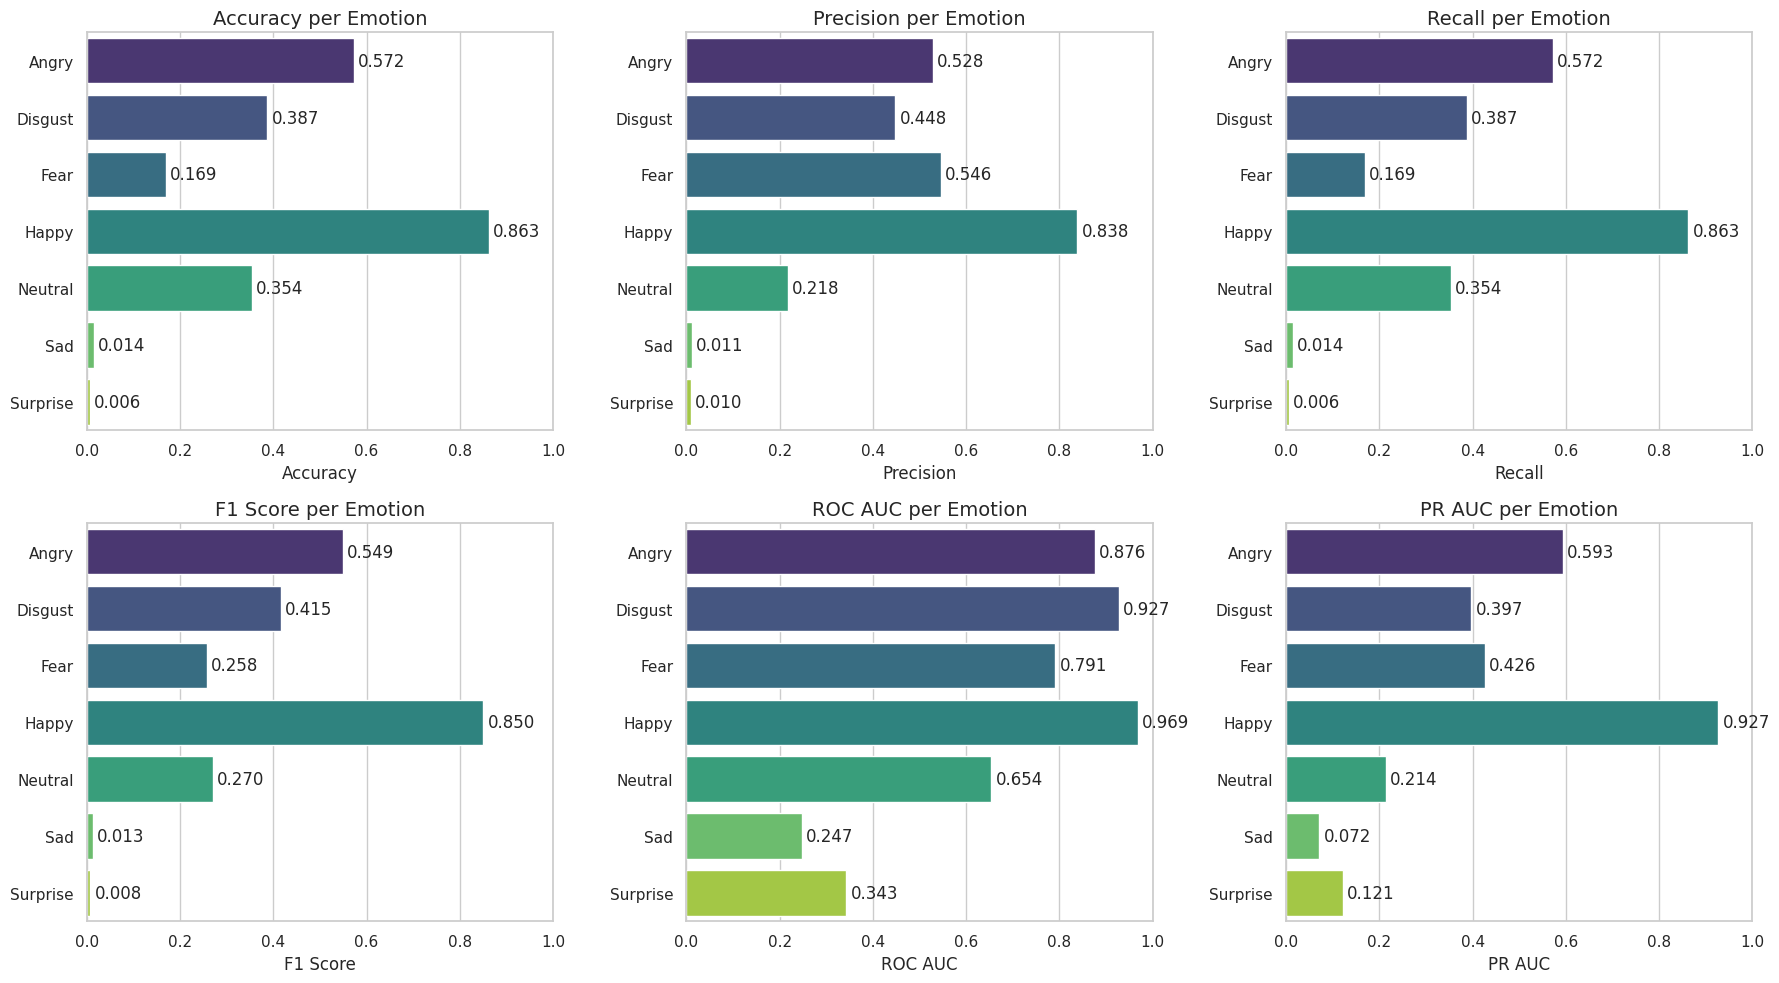

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    "Emotion": ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"],
    "Count": [958, 111, 1024, 1774, 1247, 831, 1233],
    "Accuracy": [0.5720, 0.3874, 0.1689, 0.8625, 0.3536, 0.0144, 0.0065],
    "Precision": [0.5279, 0.4479, 0.5457, 0.8384, 0.2181, 0.0114, 0.0097],
    "Recall": [0.5720, 0.3874, 0.1689, 0.8625, 0.3536, 0.0144, 0.0065],
    "F1 Score": [0.5491, 0.4155, 0.2580, 0.8502, 0.2698, 0.0127, 0.0078],
    "ROC AUC": [0.8757, 0.9270, 0.7909, 0.9686, 0.6538, 0.2475, 0.3428],
    "PR AUC": [0.5934, 0.3973, 0.4264, 0.9272, 0.2141, 0.0716, 0.1215]
}
df = pd.DataFrame(data)

# Plot setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "PR AUC"]

# Plotting with annotations
for ax, metric in zip(axes.flatten(), metrics):
    bars = sns.barplot(x=metric, y="Emotion", data=df, palette="viridis", ax=ax)
    ax.set_title(f"{metric} per Emotion", fontsize=14)
    ax.set_xlim(0, 1)
    ax.set_xlabel(metric)
    ax.set_ylabel("")

    for container in bars.containers:
        bars.bar_label(container, fmt="%.3f", label_type="edge", padding=3)

plt.tight_layout()
plt.savefig("fer2013_metrics.png", dpi=300)
plt.show()
